# Predicting Life Expectancy from Health Data

![WHO](https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/gartner_2020/WHO.png)

**Note**: You should be able to run the notebook starting from section 2, or section 3, or the "what if?" cells at the end without running prior cells.

## 1. Data Preparation

The first major task is to access and evaluate the data. This work might be performed by a data engineering team, who is more familiar with Scala than, for example, Python. Within Databricks, both teams can choose the best language for their work and still collaborate easily even within a notebook.

Data comes from several sources.

- The WHO Health Indicators (primary data) for:
  - the USA: https://data.humdata.org/dataset/who-data-for-united-states-of-america
  - similarly for other developed nations: Australia, Denmark, Finland, France, Germany, Iceland, Italy, New Zealand, Norway, Portugal, Spain, Sweden, the UK
- The World Bank Health Indicators (supplementary data) for:
  - the USA: https://data.humdata.org/dataset/world-bank-combined-indicators-for-united-states
  - similarly for other developed nations
- Our World In Data (Drug Use)
  - https://ourworldindata.org/drug-use
  
### Health Indicators primary data

The "health indicators" datasets are the primary data sets. They are CSV files, and are easily read by Spark. However, they don't have a consistent schema. Some contains extra "DATASOURCE" columns, which can be ignored.

In [0]:
%pip install shap

Python interpreter will be restarted.
Collecting shap
 Downloading shap-0.36.0.tar.gz (319 kB)
Requirement already satisfied: numpy in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from shap) (1.18.1)
Requirement already satisfied: scipy in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from shap) (1.4.1)
Requirement already satisfied: scikit-learn in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from shap) (0.22.1)
Requirement already satisfied: pandas in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from shap) (1.0.1)
Requirement already satisfied: tqdm>4.25.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from shap) (4.42.1)
Collecting slicer
 Downloading slicer-0.0.4-py3-none-any.whl (13 kB)
Collecting numba
 Downloading numba-0.51.2-cp37-cp37m-manylinux2014_x86_64.whl (3.1 MB)
Requirement already satisfied: joblib>=0.11 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from scikit-learn->shap) (0.14.1)
Requirement already satisfied: python-dateutil>=2.6.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from pandas->shap) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from pandas->shap) (2019.3)
Collecting llvmlite<0.35,>=0.34.0.dev0
 Downloading llvmlite-0.34.0-cp37-cp37m-manylinux2010_x86_64.whl (24.6 MB)
Requirement already satisfied: setuptools in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from numba->shap) (45.2.0.post20200210)
Requirement already satisfied: six>=1.5 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-50fca293-7ff1-4593-8432-7cc509048ed8/lib/python3.7/site-packages (from python-dateutil>=2.6.1->pandas->shap) (1.14.0)
Building wheels for collected packages: shap
 Building wheel for shap (setup.py): started
 Building wheel for shap (setup.py): finished with status 'done'
 Created wheel for shap: filename=shap-0.36.0-cp37-cp37m-linux_x86_64.whl size=461297 sha256=99616565f03ce76d2be56c00d590ff7b8ffd94adf35f01ee9923d01a3ad9d739
 Stored in directory: /root/.cache/pip/wheels/6b/1e/4a/b1d65778aac48b677ac2a758251f9cccb338775e8d174f3696
Successfully built shap
Installing collected packages: slicer, llvmlite, numba, shap
Successfully installed llvmlite-0.34.0 numba-0.51.2 shap-0.36.0 slicer-0.0.4
Python interpreter will be restarted.

In [0]:
%scala
import org.apache.spark.sql.DataFrame

val rawDataPath = "/mnt/databricks-datasets-private/ML/gartner_2020/"

def transformCSV(path: String): DataFrame = {
  // Second row contains odd "comment" lines that intefere with schema validation. Filter, then parse as CSV
  val withoutComment = spark.read.text(path).filter(!$"value".startsWith("#")).as[String]
  spark.read.option("inferSchema", true).option("header", true).csv(withoutComment)
}

// Some "Health Indicators" files have three extra "DATASOURCE" columns; ignore them
var rawHealthIndicators =
  transformCSV(rawDataPath + "health_indicators/format2").union(
  transformCSV(rawDataPath + "health_indicators/format1").drop("DATASOURCE (CODE)", "DATASOURCE (DISPLAY)", "DATASOURCE (URL)"))

display(rawHealthIndicators)

GHO (CODE) GHO (DISPLAY) GHO (URL) PUBLISHSTATE (CODE) PUBLISHSTATE (DISPLAY) PUBLISHSTATE (URL) YEAR (CODE) YEAR (DISPLAY) YEAR (URL) REGION (CODE) REGION (DISPLAY) REGION (URL) WORLDBANKINCOMEGROUP (CODE) WORLDBANKINCOMEGROUP (DISPLAY) WORLDBANKINCOMEGROUP (URL) COUNTRY (CODE) COUNTRY (DISPLAY) COUNTRY (URL) SEX (CODE) SEX (DISPLAY) SEX (URL) Display Value Numeric Low High StdErr StdDev Comments CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1972 1972 null WPR Western Pacific null null null null NZL New Zealand null null null null 3 null null null null null null CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1987 1987 null WPR Western Pacific null null null null NZL New Zealand null null null null 2 null null null null null null CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1990 1990 null WPR Western Pacific null null null null NZL New Zealand null null null null 5 null null null null null null CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1994 1994 null WPR Western Pacific null null null null NZL New Zealand null null null null 2 null null null null null null CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1995 1995 null WPR Western Pacific null null null null NZL New Zealand null null null null 2 null null null null null null CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1998 1998 null WPR Western Pacific null null null null NZL New Zealand null null null null 1 null null null null null 1 of 1 reported cases are imported. CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 1999 1999 null WPR Western Pacific null null null null NZL New Zealand null null null null 1 null null null null null 1 of 1 reported cases are imported. CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 2001 2001 null WPR Western Pacific null null null null NZL New Zealand null null null null 1 null null null null null 1 of 1 reported cases are imported. CHOLERA_0000000001 Number of reported cases of cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/42 PUBLISHED Published null 2005 2005 null WPR Western Pacific null null null null NZL New Zealand null null null null 1 null null null null null 1 of 1 reported cases are imported. CHOLERA_0000000002 Number of reported deaths from cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2446 PUBLISHED Published null 1972 1972 null WPR Western Pacific null null null null NZL New Zealand null null null null 1 1.0 null null null null null CHOLERA_0000000002 Number of reported deaths from cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2446 PUBLISHED Published null 1987 1987 null WPR Western Pacific null null null null NZL New Zealand null null null null 0 0.0 null null null null null CHOLERA_0000000002 Number of reported deaths from cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2446 PUBLISHED Published null 1990 1990 null WPR Western Pacific null null null null NZL New Zealand null null null null 0 0.0 null null null null null CHOLERA_0000000002 Number of reported deaths from cholera https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2446 PUBLISHED Published null 1994 1

Save the descriptions for codes for later use. The data contains 109 distinct indicators for the 14 countries:

In [0]:
%fs rm --recurse=true /tmp/KnowledgeRepo/ML/gartner_2020/descriptions

res2: Boolean = true

In [0]:
%scala
rawHealthIndicators.select("GHO (CODE)", "GHO (DISPLAY)").distinct().toDF("Code", "Description").
  write.format("delta").save("/tmp/KnowledgeRepo/ML/gartner_2020/descriptions")
display(spark.read.format("delta").load("/tmp/KnowledgeRepo/ML/gartner_2020/descriptions").orderBy("Code"))

Code Description CHOLERA_0000000001 Number of reported cases of cholera CHOLERA_0000000002 Number of reported deaths from cholera CHOLERA_0000000003 Cholera case fatality rate CM_01 Number of under-five deaths (thousands) CM_02 Number of infant deaths (thousands) CM_03 Number of neonatal deaths (thousands) DEVICES09 Total density per million population: Computed tomography units DEVICES22 Total density per million population: Radiotherapy units HIV_0000000020 Estimated percentage of pregnant women living with HIV who received antiretrovirals for preventing mother-to-child transmission MDG_0000000001 Infant mortality rate (probability of dying between birth and age 1 per 1000 live births) MDG_0000000003 Adolescent birth rate (per 1000 women aged 15-19 years) MDG_0000000005 Contraceptive prevalence (%) MDG_0000000006 Unmet need for family planning (%) MDG_0000000007 Under-five mortality rate (probability of dying by age 5 per 1000 live births) MDG_0000000017 Deaths due to tuberculosis among HIV-negative people (per 100 000 population) MDG_0000000020 Incidence of tuberculosis (per 100 000 population per year) MDG_0000000023 Prevalence of tuberculosis (per 100 000 population) MDG_0000000025 Births attended by skilled health personnel (%) MDG_0000000026 Maternal mortality ratio (per 100 000 live births) MDG_0000000027 Children aged <5 years stunted (%) MDG_0000000029 Prevalence of HIV among adults aged 15 to 49 (%) MDG_0000000031 Smear-positive tuberculosis treatment-success rate (%) MDG_0000000033 Antiretroviral therapy coverage among people with HIV infection eligible for ART according to 2010 guidelines (%) MH_17 Mental hospitals (per 100 000 population) MH_18 Mental health units in general hospitals (per 100 000 population) MH_6 Psychiatrists working in mental health sector (per 100 000 population) NUTRITION_564 Children aged <5 years wasted for age (%) SA_0000001688 Total (recorded+unrecorded) alcohol per capita (15+) consumption TB_1 Tuberculosis treatment coverage TB_tot_newrel Tuberculosis - new and relapse cases TOBACCO_0000000192 Prevalence of smoking any tobacco product among persons aged >= 15 years WHOSIS_000001 Life expectancy at birth (years) WHOSIS_000003 Neonatal mortality rate (per 1000 live births) WHOSIS_000005 Low-birth-weight newborns (%) WHOSIS_000009 Children aged <5 years overweight (%) WHOSIS_000015 Life expectancy at age 60 (years) WHS10_1 Most recent census (year) WHS10_8 Civil registration coverage of cause-of-death (%) WHS10_9 Ill-defined causes in cause-of-death registration (%) WHS2_138 Deaths due to HIV/AIDS (per 100 000 population) WHS2_164 Distribution of causes of death among children aged <5 years (%) - Malaria WHS2_165 Distribution of causes of death among children aged <5 years (%) - Pneumonia WHS2_166 Distribution of causes of death among children aged <5 years (%) - Injuries WHS2_167 Distribution of causes of death among children aged <5 years (%) - Diarrhoea WHS2_168 Distribution of causes of death among children aged <5 years (%) - Measles WHS2_170 Distribution of causes of death among children aged <5 years (%) - HIV/AIDS WHS2_171 Distribution of causes of death among children aged <5 years (%) - Other diseases WHS2_174 Distribution of years of life lost by broader causes (%) - Injuries WHS2_514 Distribution of causes of death among children aged <5 years (%) - Prematurity WHS2_515 Distribution of causes of death among children aged <5 years (%) - Neonatal sepsis WHS2_516 Distribution of causes of death among children aged <5 years (%) - Congenital anomalies WHS2_523 Distribution of causes of death among children aged <5 years (%) - Birth asphyxia WHS3_40 Cholera - number of reported cases WHS3_41 Diphtheria - number of reported cases WHS3_42 Japanese encephalitis - number of reported cases WHS3_43 Pertussis - number of reported cases WHS3_45 Number of new leprosy cases WHS3_46 Total tetanus - number of reported cases WHS3_49 Poliomyelitis - number of reported cases WHS3_50 Yellow fever -

The data needs some basic normalization and filtering:
- Remove any variables that are effectively variations on life expectancy, as this is the variable to be explained
- Use published data only
- For now, use data for both sexes, not male/female individually
- Correctly parse the Value / Display Value, which are inconsistently available
- Flatten year ranges like "2012-2017" to individual years
- Keep only data from 2000 onwards

Finally, the data needs to be 'pivoted' to contain indicator values as columns.

In [0]:
%scala
import org.apache.spark.sql.functions.{explode, when, udf}
import org.apache.spark.sql.types.FloatType

// Can't use life expectancy at 60
rawHealthIndicators = rawHealthIndicators.filter($"GHO (CODE)" =!= "WHOSIS_000015")

// Keep just PUBLISHED data, not VOID
rawHealthIndicators = rawHealthIndicators.filter($"PUBLISHSTATE (CODE)" === "PUBLISHED").drop("PUBLISHSTATE (CODE)")

// Use stats for both sexes now, not male/female separately. It's either NULL or BTSX
rawHealthIndicators = rawHealthIndicators.filter(($"SEX (CODE)".isNull) || ($"SEX (CODE)" === "BTSX")).drop("SEX (CODE)")

// Use Numeric where available, otherwise Display Value, as value. Low/High/StdErr/StdDev are unevenly available, so drop
rawHealthIndicators = rawHealthIndicators.
  withColumn("Value", when($"Numeric".isNull, $"Display Value").otherwise($"Numeric"))

// Some "year" values are like 2012-2017. Explode to a value for each year in the range
val yearsToRangeUDF = udf { (s: String) =>
    if (s.contains("-")) {
      val Array(start, end) = s.split("-")
      (start.toInt to end.toInt).toArray
    } else {
      Array(s.toInt)
    }
  }
rawHealthIndicators = rawHealthIndicators.withColumn("Year", explode(yearsToRangeUDF($"YEAR (CODE)")))

// Rename columns, while dropping everything but Year, Country, GHO CODE, and Value
rawHealthIndicators = rawHealthIndicators.select(
  $"GHO (CODE)".alias("GHO"), $"Year", $"COUNTRY (CODE)".alias("Country"), $"Value".cast(FloatType))

// Keep only 2000-2018 at most
rawHealthIndicators = rawHealthIndicators.filter("Year >= 2000 AND Year <= 2018")

// avg() because some values will exist twice because of WORLDBANKINCOMEGROUP; value is virtually always the same
val healthIndicatorsDF = rawHealthIndicators.groupBy("Country", "Year").pivot("GHO").avg("Value")
healthIndicatorsDF.createOrReplaceTempView("healthIndicators")

import org.apache.spark.sql.functions.{explode, when, udf}
import org.apache.spark.sql.types.FloatType
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
yearsToRangeUDF: org.apache.spark.sql.expressions.UserDefinedFunction = SparkUserDefinedFunction($Lambda$11202/170725761@1fb3c20b,ArrayType(IntegerType,false),List(Some(class[value[0]: string])),None,true,true)
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
rawHealthIndicators: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [GHO: string, Year: int ... 2 more fields]
healthIndicatorsDF: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 95 more fields]

In [0]:
%sql
SELECT * FROM healthIndicators ORDER BY Country, Year

Country Year CHOLERA_0000000001 CHOLERA_0000000002 CHOLERA_0000000003 CM_01 CM_02 CM_03 DEVICES09 DEVICES22 HIV_0000000020 MDG_0000000001 MDG_0000000005 MDG_0000000006 MDG_0000000007 MDG_0000000017 MDG_0000000020 MDG_0000000023 MDG_0000000025 MDG_0000000026 MDG_0000000027 MDG_0000000029 MDG_0000000031 MDG_0000000033 MH_17 MH_18 MH_6 NUTRITION_564 SA_0000001688 TB_1 TB_tot_newrel WHOSIS_000001 WHOSIS_000003 WHOSIS_000005 WHOSIS_000009 WHS10_1 WHS10_8 WHS10_9 WHS2_138 WHS2_174 WHS3_40 WHS3_41 WHS3_42 WHS3_43 WHS3_45 WHS3_46 WHS3_49 WHS3_50 WHS3_52 WHS3_53 WHS3_55 WHS3_56 WHS3_57 WHS3_62 WHS4_100 WHS4_111 WHS4_115 WHS4_117 WHS4_129 WHS4_154 WHS6_102 WHS6_123 WHS6_127 WHS6_140 WHS6_144 WHS6_148 WHS6_150 WHS6_517 WHS6_518 WHS6_519 WHS6_520 WHS7_103 WHS7_104 WHS7_105 WHS7_108 WHS7_113 WHS7_120 WHS7_134 WHS7_139 WHS7_143 WHS7_147 WHS7_149 WHS7_156 WHS8_110 WHS9_85 WHS9_86 WHS9_88 WHS9_89 WHS9_90 WHS9_91 WHS9_92 WHS9_93 WHS9_95 WHS9_96 WHS9_CBR WHS9_CDR WHS9_CS AUS 2000 1.0 null null 1531.0 1262.0 870.0 null null null 5.115719795227051 null null 6.186699867248535 0.28999999165534973 6.300000190734863 7.699999809265137 null 7.0 null 0.10000000149011612 72.0 null null null null null null 87.0 1043.0 79.64923095703125 3.5268900394439697 7.0 null null 99.38999938964844 null null null null 0.0 null 5795.0 null 7.0 0.0 null null 212.0 null null 313.0 108.0 90.0 null null null 90.0 null null null null null null null null null null null null 21.82377052307129 1166.99365234375 2298.604248046875 1536.40966796875 16.00274085998535 null 0.0 59.66539001464844 8.078149795532227 33.159019470214844 66.84098052978516 1745.92529296875 91.0 null null null null null null null 25580.0 null 87.16500091552734 null null null AUS 2001 2.0 null null 1504.0 1244.0 866.0 null null null 5.03164005279541 null null 6.078229904174805 0.44999998807907104 5.900000095367432 7.5 null 6.0 null null 70.0 null null null null null null 87.0 980.0 80.0813217163086 3.492919921875 null null null 99.38999938964844 null 0.30000001192092896 null null 1.0 null 9538.0 null 3.0 0.0 0.0 null 113.0 0.0 null 262.0 141.0 92.0 null null 94.0 95.0 null null null null null null null null null null null null 24.422040939331055 1103.7294921875 2426.96435546875 1608.642578125 15.696240425109863 null 0.0 57.099578857421875 8.178680419921875 33.717918395996094 66.2820816040039 1665.2003173828125 92.0 null null null null null null null 26680.0 null null null null null AUS 2002 5.0 null null 1492.0 1238.0 863.0 null null null 4.962480068206787 null null 5.987460136413574 0.3499999940395355 6.0 7.400000095367432 null 6.0 null null 78.0 null null null null null null 87.0 1013.0 80.15123748779297 3.4374799728393555 null null null 99.38999938964844 null null null null 0.0 null 5563.0 null 2.0 0.0 0.0 null 68.0 1.0 null 253.0 32.0 92.0 null null 95.0 95.0 null null null null null null null null null null null null 24.668609619140625 1261.612060546875 2593.626220703125 1737.4410400390625 16.456289291381836 null 0.0 56.772308349609375 8.390439987182617 33.011131286621094 66.9888687133789 1883.3157958984375 94.0 null null null null null null null 27920.0 null null null null null AUS 2003 null null null 1491.0 1242.0 863.0 null null null 4.900279998779297 null null 5.90526008605957 0.27000001072883606 5.599999904632568 7.5 null 6.0 null null 80.0 null null null null null null 87.0 949.0 80.56198120117188 3.3713600635528564 null null null 99.38999938964844 null null null null 0.0 null 4968.0 null 3.0 0.0 0.0 null 76.0 1.0 null 56.0 91.0 93.0 null null 95.0 95.0 null null null null null null null null null null null null 24.428510665893555 1569.3270263671875 2696.322265625 1784.7425537109375 16.32155990600586 null 0.0 53.784088134765625 8.318449974060059 33.80826187133789 66.19174194335938 2370.880615234375 94.0 null null null null null null null 28960.0 null null null null null AUS 2004 2.0 0.0 0.0 1500.0 1254.0 867.0 null null null 4.837850093841553 null null 5.822850227355957 0.3199999928474426 6.1999998

This data set contains life expectancy (`WHOSIS_000001`), so we can already compare life expectancy from 2000-2016 across countries. The USA is an outlier, it seems.

In [0]:
%sql
SELECT Year, Country, WHOSIS_000001 AS LifeExpectancy FROM healthIndicators WHERE Year <= 2016

Year Country LifeExpectancy 2006 FRA 80.77184295654297 2011 ESP 82.35428619384766 2007 DEU 79.87753295898438 2012 USA 78.9529800415039 2003 DEU 78.70458221435547 2000 GBR 77.91763305664062 2009 USA 78.5839614868164 2009 FRA 81.23290252685547 2002 ITA 80.27699279785156 2002 GBR 78.31536102294922 2015 DEU 80.63511657714844 2010 IRL 80.86634826660156 2007 SWE 81.0447769165039 2000 NOR 78.75833892822266 2002 NZL 78.96221160888672 2000 DNK 77.08438873291016 2004 AUS 80.84269714355469 2008 DNK 78.96906280517578 2000 PRT 76.88587188720703 2007 ESP 81.13643646240234 2015 IRL 81.39015197753906 2013 DEU 80.55142974853516 2002 FRA 79.5101089477539 2016 AUS 82.90017700195312 2015 FRA 82.6678237915039 2007 ITA 81.47754669189453 2010 PRT 79.97952270507812 2006 NZL 80.12825012207031 2003 NOR 79.70053100585938 2005 PRT 78.59058380126953 2009 ESP 81.8138198852539 2010 SWE 81.54234313964844 2016 FRA 82.9460220336914 2015 FIN 81.39797973632812 2008 SWE 81.22457122802734 2008 FIN 79.82515716552734 2006 DNK 78.3756103515625 2001 NOR 79.0338134765625 2001 AUS 80.0813217163086 2005 FRA 80.28153228759766 2013 FIN 80.93609619140625 2014 GBR 81.42310333251953 2004 ESP 80.39457702636719 2004 ITA 81.03214263916016 2016 NOR 82.47630310058594 2011 PRT 80.5239028930664 2006 DEU 79.68672180175781 2009 ISL 81.68534851074219 2001 GBR 78.1727066040039 2012 DNK 80.31646728515625 2010 ISL 81.85382843017578 2008 NZL 80.4088363647461 2012 GBR 81.12748718261719 2008 USA 78.26241302490234 2001 DEU 78.49681091308594 2003 FRA 79.5013198852539 2014 IRL 81.37145233154297 2014 DNK 80.9018325805664 2012 PRT 80.53874206542969 2004 PRT 78.28251647949219 2014 DEU 81.01007080078125 2005 IRL 78.83062744140625 2002 USA 77.13555145263672 2000 ITA 79.62312316894531 2015 ISL 82.39936828613281 2002 ISL 80.71708679199219 2007 IRL 79.65735626220703 2003 DNK 77.58341979980469 2004 SWE 80.44793701171875 2009 GBR 80.41708374023438 2007 FRA 81.01750183105469 2015 USA 78.62655639648438 2014 FRA 82.56790161132812 2012 IRL 80.8650131225586 2006 ISL 81.19303131103516 2002 DEU 78.61576843261719 2005 SWE 80.61920166015625 2007 PRT 79.32829284667969 2001 NZL 78.68399810791016 2013 ESP 82.89678955078125 2002 FIN 78.43203735351562 2003 USA 77.29466247558594 2009 PRT 79.8354721069336 2000 FIN 77.77102661132812 2003 GBR 78.44397735595703 2006 FIN 79.4626235961914 2010 DNK 79.39053344726562 2000 NZL 78.80196380615234 2010 AUS 82.03266143798828 2005 GBR 79.12409210205078 2016 ISL 82.39584350585938 2012 SWE 81.84496307373047 2007 FIN 79.50602722167969 2006 GBR 79.50961303710938 2004 GBR 78.96793365478516 2004 ISL 81.03910064697266 2014 SWE 82.25570678710938 2002 NOR 79.14275360107422 2003 PRT 77.60259246826172 2004 FIN 78.95467376708984 2010 DEU 80.12474822998047 2000 SWE 79.74405670166016 2012 FRA 81.80441284179688 2011 NZL 80.98924255371094 2003 FIN 78.7317886352539 2011 USA 78.8199462890625 2009 AUS 81.88072204589844 2010 USA 78.716552734375 2000 ESP 79.3720932006836 2016 FIN 81.44721221923828 2000 IRL 76.41195678710938 2015 SWE 82.14144134521484 2001 DNK 77.2406005859375 2005 DEU 79.29794311523438 2006 AUS 81.44938659667969 2005 ISL 81.14512634277344 2014 ESP 83.01248168945312 2014 NZL 81.8563003540039 2004 IRL 78.45681762695312 2007 ISL 81.26934814453125 2011 GBR 81.05516815185547 2008 FRA 81.0986328125 2014 FIN 81.10089874267578 2012 ITA 82.19212341308594 2014 NOR 82.22633361816406 2013 ITA 82.57720184326172 2001 IRL 77.08223724365234 2007 NZL 80.3294677734375 2015 ITA 82.42330169677734 2000 FRA 79.11186218261719 2000 USA 76.91159057617188 2007 USA 78.1887435913086 2002 SWE 80.06709289550781 2011 IRL 80.72496032714844 2007 DNK 78.60397338867188 2010 ITA 82.04792785644531 2007 AUS 81.49349212646484 2001 ISL 80.24545288085938 2011 AUS 82.19225311279297 2013 FRA 82.11892700195312 2013 USA 78.94818115234375 2009 ITA 81.75298309326172 2005 ITA 80.94136810302734 2003 SWE 80.32272338867188 2016 ESP 83.07911682128906 2013 DNK 80.55735778808594 2009 FIN 79.91969299316406 2016 PRT 81.5262680053711 2002 IRL

### Indicators supplementary data
The data from the World Bank can likewise be normalized, filtered and analyzed.

In [0]:
%scala
var rawIndicators = transformCSV(rawDataPath + "indicators")
display(rawIndicators)

Country Name Country ISO3 Year Indicator Name Indicator Code Value Australia AUS 1974 Agricultural machinery, tractors AG.AGR.TRAC.NO 332560.0 Australia AUS 1973 Agricultural machinery, tractors AG.AGR.TRAC.NO 334448.0 Australia AUS 1972 Agricultural machinery, tractors AG.AGR.TRAC.NO 333046.0 Australia AUS 1971 Agricultural machinery, tractors AG.AGR.TRAC.NO 331417.0 Australia AUS 1970 Agricultural machinery, tractors AG.AGR.TRAC.NO 326725.0 Australia AUS 1969 Agricultural machinery, tractors AG.AGR.TRAC.NO 330034.0 Australia AUS 1968 Agricultural machinery, tractors AG.AGR.TRAC.NO 323596.0 Australia AUS 1967 Agricultural machinery, tractors AG.AGR.TRAC.NO 323982.0 Australia AUS 1966 Agricultural machinery, tractors AG.AGR.TRAC.NO 314670.0 Australia AUS 1965 Agricultural machinery, tractors AG.AGR.TRAC.NO 300859.0 Australia AUS 1964 Agricultural machinery, tractors AG.AGR.TRAC.NO 295502.0 Australia AUS 1963 Agricultural machinery, tractors AG.AGR.TRAC.NO 283748.0 Australia AUS 1962 Agricultural machinery, tractors AG.AGR.TRAC.NO 271060.0 Australia AUS 1961 Agricultural machinery, tractors AG.AGR.TRAC.NO 264069.0 Australia AUS 2016 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 222.056362564107 Australia AUS 2015 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 243.439416196665 Australia AUS 2014 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 276.775024975575 Australia AUS 2013 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 218.897551594056 Australia AUS 2012 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 267.738443666187 Australia AUS 2011 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 242.33090269047 Australia AUS 2010 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 282.420485082537 Australia AUS 2009 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 152.631029991776 Australia AUS 2008 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 215.555870006132 Australia AUS 2007 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 181.130964068329 Australia AUS 2006 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 224.654952007453 Australia AUS 2005 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 236.904451353282 Australia AUS 2004 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 252.3457676572 Australia AUS 2003 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 231.103314461898 Australia AUS 2002 Fertilizer consumption (% of fertilizer production) AG.CON.FERT.PT.ZS 229.265479301778 Australia AUS 2016 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 68.103696143155 Australia AUS 2015 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 53.5625677492087 Australia AUS 2014 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 54.1858508848521 Australia AUS 2013 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 49.2000043272247 Australia AUS 2012 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 46.6197227941333 Australia AUS 2011 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 45.2787449137967 Australia AUS 2010 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 46.3164818643112 Australia AUS 2009 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 36.2504384426517 Australia AUS 2008 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 42.6044248391278 Australia AUS 2007 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 46.8146805618487 Australia AUS 2006 Fertilizer consumption (kilograms per hectare of arable land) AG.CON.FERT.ZS 43.4601278423976 Australia AUS 2005 Fertilizer consumptio

This data set has 2,283 (!) features for these countries, by year. As above, many are highly correlated, and even redundant for comparative purposes. For example, figures in local currency are less useful for comparison than the ones expressed in US$. Likewise to limit the scale of the feature set, male/female figures reported separately are removed.

In [0]:
%scala
rawIndicators.select("Indicator Code", "Indicator Name").distinct().toDF("Code", "Description").
  write.format("delta").mode("append").save("/tmp/KnowledgeRepo/ML/gartner_2020/descriptions")
display(spark.read.format("delta").load("/tmp/KnowledgeRepo/ML/gartner_2020/descriptions").orderBy("Code"))

Code Description AG.AGR.TRAC.NO Agricultural machinery, tractors AG.CON.FERT.PT.ZS Fertilizer consumption (% of fertilizer production) AG.CON.FERT.ZS Fertilizer consumption (kilograms per hectare of arable land) AG.LND.AGRI.K2 Agricultural land (sq. km) AG.LND.AGRI.ZS Agricultural land (% of land area) AG.LND.ARBL.HA Arable land (hectares) AG.LND.ARBL.HA.PC Arable land (hectares per person) AG.LND.ARBL.ZS Arable land (% of land area) AG.LND.CREL.HA Land under cereal production (hectares) AG.LND.CROP.ZS Permanent cropland (% of land area) AG.LND.EL5M.RU.K2 Rural land area where elevation is below 5 meters (sq. km) AG.LND.EL5M.RU.ZS Rural land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.UR.K2 Urban land area where elevation is below 5 meters (sq. km) AG.LND.EL5M.UR.ZS Urban land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS Land area where elevation is below 5 meters (% of total land area) AG.LND.FRST.K2 Forest area (sq. km) AG.LND.FRST.ZS Forest area (% of land area) AG.LND.IRIG.AG.ZS Agricultural irrigated land (% of total agricultural land) AG.LND.PRCP.MM Average precipitation in depth (mm per year) AG.LND.TOTL.K2 Land area (sq. km) AG.LND.TOTL.RU.K2 Rural land area (sq. km) AG.LND.TOTL.UR.K2 Urban land area (sq. km) AG.LND.TRAC.ZS Agricultural machinery, tractors per 100 sq. km of arable land AG.PRD.CREL.MT Cereal production (metric tons) AG.PRD.CROP.XD Crop production index (2004-2006 = 100) AG.PRD.FOOD.XD Food production index (2004-2006 = 100) AG.PRD.LVSK.XD Livestock production index (2004-2006 = 100) AG.SRF.TOTL.K2 Surface area (sq. km) AG.YLD.CREL.KG Cereal yield (kg per hectare) BAR.NOED.1519.FE.ZS Barro-Lee: Percentage of female population age 15-19 with no education BAR.NOED.1519.ZS Barro-Lee: Percentage of population age 15-19 with no education BAR.NOED.15UP.FE.ZS Barro-Lee: Percentage of female population age 15+ with no education BAR.NOED.15UP.ZS Barro-Lee: Percentage of population age 15+ with no education BAR.NOED.2024.FE.ZS Barro-Lee: Percentage of female population age 20-24 with no education BAR.NOED.2024.ZS Barro-Lee: Percentage of population age 20-24 with no education BAR.NOED.2529.FE.ZS Barro-Lee: Percentage of female population age 25-29 with no education BAR.NOED.2529.ZS Barro-Lee: Percentage of population age 25-29 with no education BAR.NOED.25UP.FE.ZS Barro-Lee: Percentage of female population age 25+ with no education BAR.NOED.25UP.ZS Barro-Lee: Percentage of population age 25+ with no education BAR.NOED.3034.FE.ZS Barro-Lee: Percentage of female population age 30-34 with no education BAR.NOED.3034.ZS Barro-Lee: Percentage of population age 30-34 with no education BAR.NOED.3539.FE.ZS Barro-Lee: Percentage of female population age 35-39 with no education BAR.NOED.3539.ZS Barro-Lee: Percentage of population age 35-39 with no education BAR.NOED.4044.FE.ZS Barro-Lee: Percentage of female population age 40-44 with no education BAR.NOED.4044.ZS Barro-Lee: Percentage of population age 40-44 with no education BAR.NOED.4549.FE.ZS Barro-Lee: Percentage of female population age 45-49 with no education BAR.NOED.4549.ZS Barro-Lee: Percentage of population age 45-49 with no education BAR.NOED.5054.FE.ZS Barro-Lee: Percentage of female population age 50-54 with no education BAR.NOED.5054.ZS Barro-Lee: Percentage of population age 50-54 with no education BAR.NOED.5559.FE.ZS Barro-Lee: Percentage of female population age 55-59 with no education BAR.NOED.5559.ZS Barro-Lee: Percentage of population age 55-59 with no education BAR.NOED.6064.FE.ZS Barro-Lee: Percentage of female population age 60-64 with no education BAR.NOED.6064.ZS Barro-Lee: Percentage of population age 60-64 with no education BAR.POP.1519 Barro-Lee: Population in thousands, age 15-19, total BAR.POP.1519.FE Barro-Lee: Population in thousands, age 15-19, female BAR.POP.15UP Barro-Lee: Population in thousands, age 15+, total BAR.POP.15UP.FE Barro-Lee: Population in thousands, age 15+, female 

In [0]:
%scala
// Keep only 2000-2018 at most
rawIndicators = rawIndicators.filter("Year >= 2000 AND Year <= 2018")

// Can't use life expectancy from World Bank, or mortality rates or survival rates -- too closely related to life expectancy
rawIndicators = rawIndicators.
  filter(!$"Indicator Code".startsWith("SP.DYN.LE")).
  filter(!$"Indicator Code".startsWith("SP.DYN.AMRT")).filter(!$"Indicator Code".startsWith("SP.DYN.TO"))

// Don't use gender columns separately for now
rawIndicators = rawIndicators.
  filter(!$"Indicator Code".endsWith(".FE") && !$"Indicator Code".endsWith(".MA")).
  filter(!$"Indicator Code".contains(".FE.") && !$"Indicator Code".contains(".MA."))

// Don't use local currency variants
rawIndicators = rawIndicators.
  filter(!$"Indicator Code".endsWith(".CN") && !$"Indicator Code".endsWith(".KN")).
  filter(!$"Indicator Code".startsWith("PA.") && !$"Indicator Code".startsWith("PX."))

rawIndicators = rawIndicators.select($"Country ISO3".alias("Country"), $"Year", $"Indicator Code".alias("Indicator"), $"Value")

val indicatorsDF = rawIndicators.groupBy("Country", "Year").pivot("Indicator").avg("Value")
indicatorsDF.createOrReplaceTempView("indicators")

rawIndicators: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 2 more fields]
rawIndicators: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 2 more fields]
rawIndicators: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 2 more fields]
rawIndicators: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 2 more fields]
rawIndicators: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 2 more fields]
indicatorsDF: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 1572 more fields]

In [0]:
%sql
SELECT * FROM indicators

Country Year AG.AGR.TRAC.NO AG.CON.FERT.PT.ZS AG.CON.FERT.ZS AG.LND.AGRI.K2 AG.LND.AGRI.ZS AG.LND.ARBL.HA AG.LND.ARBL.HA.PC AG.LND.ARBL.ZS AG.LND.CREL.HA AG.LND.CROP.ZS AG.LND.EL5M.RU.K2 AG.LND.EL5M.RU.ZS AG.LND.EL5M.UR.K2 AG.LND.EL5M.UR.ZS AG.LND.EL5M.ZS AG.LND.FRST.K2 AG.LND.FRST.ZS AG.LND.IRIG.AG.ZS AG.LND.PRCP.MM AG.LND.TOTL.K2 AG.LND.TOTL.RU.K2 AG.LND.TOTL.UR.K2 AG.LND.TRAC.ZS AG.PRD.CREL.MT AG.PRD.CROP.XD AG.PRD.FOOD.XD AG.PRD.LVSK.XD AG.SRF.TOTL.K2 AG.YLD.CREL.KG BAR.NOED.1519.ZS BAR.NOED.15UP.ZS BAR.NOED.2024.ZS BAR.NOED.2529.ZS BAR.NOED.25UP.ZS BAR.NOED.3034.ZS BAR.NOED.3539.ZS BAR.NOED.4044.ZS BAR.NOED.4549.ZS BAR.NOED.5054.ZS BAR.NOED.5559.ZS BAR.NOED.6064.ZS BAR.POP.1519 BAR.POP.15UP BAR.POP.2024 BAR.POP.2529 BAR.POP.25UP BAR.POP.3034 BAR.POP.3539 BAR.POP.4044 BAR.POP.4549 BAR.POP.5054 BAR.POP.5559 BAR.POP.6064 BAR.PRM.CMPT.1519.ZS BAR.PRM.CMPT.15UP.ZS BAR.PRM.CMPT.2024.ZS BAR.PRM.CMPT.2529.ZS BAR.PRM.CMPT.25UP.ZS BAR.PRM.CMPT.3034.ZS BAR.PRM.CMPT.3539.ZS BAR.PRM.CMPT.4044.ZS BAR.PRM.CMPT.4549.ZS BAR.PRM.CMPT.5054.ZS BAR.PRM.CMPT.5559.ZS BAR.PRM.CMPT.6064.ZS BAR.PRM.ICMP.1519.ZS BAR.PRM.ICMP.15UP.ZS BAR.PRM.ICMP.2024.ZS BAR.PRM.ICMP.2529.ZS BAR.PRM.ICMP.25UP.ZS BAR.PRM.ICMP.3034.ZS BAR.PRM.ICMP.3539.ZS BAR.PRM.ICMP.4044.ZS BAR.PRM.ICMP.4549.ZS BAR.PRM.ICMP.5054.ZS BAR.PRM.ICMP.5559.ZS BAR.PRM.ICMP.6064.ZS BAR.PRM.SCHL.1519 BAR.PRM.SCHL.15UP BAR.PRM.SCHL.2024 BAR.PRM.SCHL.2529 BAR.PRM.SCHL.25UP BAR.PRM.SCHL.3034 BAR.PRM.SCHL.3539 BAR.PRM.SCHL.4044 BAR.PRM.SCHL.4549 BAR.PRM.SCHL.5054 BAR.PRM.SCHL.5559 BAR.PRM.SCHL.6064 BAR.SCHL.1519 BAR.SCHL.15UP BAR.SCHL.2024 BAR.SCHL.2529 BAR.SCHL.25UP BAR.SCHL.3034 BAR.SCHL.3539 BAR.SCHL.4044 BAR.SCHL.4549 BAR.SCHL.5054 BAR.SCHL.5559 BAR.SCHL.6064 BAR.SEC.CMPT.1519.ZS BAR.SEC.CMPT.15UP.ZS BAR.SEC.CMPT.2024.ZS BAR.SEC.CMPT.2529.ZS BAR.SEC.CMPT.25UP.ZS BAR.SEC.CMPT.3034.ZS BAR.SEC.CMPT.3539.ZS BAR.SEC.CMPT.4044.ZS BAR.SEC.CMPT.4549.ZS BAR.SEC.CMPT.5054.ZS BAR.SEC.CMPT.5559.ZS BAR.SEC.CMPT.6064.ZS BAR.SEC.ICMP.1519.ZS BAR.SEC.ICMP.15UP.ZS BAR.SEC.ICMP.2024.ZS BAR.SEC.ICMP.2529.ZS BAR.SEC.ICMP.25UP.ZS BAR.SEC.ICMP.3034.ZS BAR.SEC.ICMP.3539.ZS BAR.SEC.ICMP.4044.ZS BAR.SEC.ICMP.4549.ZS BAR.SEC.ICMP.5054.ZS BAR.SEC.ICMP.5559.ZS BAR.SEC.ICMP.6064.ZS BAR.SEC.SCHL.1519 BAR.SEC.SCHL.15UP BAR.SEC.SCHL.2024 BAR.SEC.SCHL.2529 BAR.SEC.SCHL.25UP BAR.SEC.SCHL.3034 BAR.SEC.SCHL.3539 BAR.SEC.SCHL.4044 BAR.SEC.SCHL.4549 BAR.SEC.SCHL.5054 BAR.SEC.SCHL.5559 BAR.SEC.SCHL.6064 BAR.TER.CMPT.1519.ZS BAR.TER.CMPT.15UP.ZS BAR.TER.CMPT.2024.ZS BAR.TER.CMPT.2529.ZS BAR.TER.CMPT.25UP.ZS BAR.TER.CMPT.3034.ZS BAR.TER.CMPT.3539.ZS BAR.TER.CMPT.4044.ZS BAR.TER.CMPT.4549.ZS BAR.TER.CMPT.5054.ZS BAR.TER.CMPT.5559.ZS BAR.TER.CMPT.6064.ZS BAR.TER.ICMP.1519.ZS BAR.TER.ICMP.15UP.ZS BAR.TER.ICMP.2024.ZS BAR.TER.ICMP.2529.ZS BAR.TER.ICMP.25UP.ZS BAR.TER.ICMP.3034.ZS BAR.TER.ICMP.3539.ZS BAR.TER.ICMP.4044.ZS BAR.TER.ICMP.4549.ZS BAR.TER.ICMP.5054.ZS BAR.TER.ICMP.5559.ZS BAR.TER.ICMP.6064.ZS BAR.TER.SCHL.1519 BAR.TER.SCHL.15UP BAR.TER.SCHL.2024 BAR.TER.SCHL.2529 BAR.TER.SCHL.25UP BAR.TER.SCHL.3034 BAR.TER.SCHL.3539 BAR.TER.SCHL.4044 BAR.TER.SCHL.4549 BAR.TER.SCHL.5054 BAR.TER.SCHL.5559 BAR.TER.SCHL.6064 BG.GSR.NFSV.GD.ZS BM.GSR.CMCP.ZS BM.GSR.FCTY.CD BM.GSR.GNFS.CD BM.GSR.INSF.ZS BM.GSR.MRCH.CD BM.GSR.NFSV.CD BM.GSR.ROYL.CD BM.GSR.TOTL.CD BM.GSR.TRAN.ZS BM.GSR.TRVL.ZS BM.KLT.DINV.CD.WD BM.KLT.DINV.WD.GD.ZS BM.TRF.PRVT.CD BM.TRF.PWKR.CD.DT BN.CAB.XOKA.CD BN.CAB.XOKA.GD.ZS BN.FIN.TOTL.CD BN.GSR.FCTY.CD BN.GSR.GNFS.CD BN.GSR.MRCH.CD BN.KAC.EOMS.CD BN.KLT.DINV.CD BN.KLT.PTXL.CD BN.RES.INCL.CD BN.TRF.CURR.CD BN.TRF.KOGT.CD BX.GSR.CCIS.CD BX.GSR.CCIS.ZS BX.GSR.CMCP.ZS BX.GSR.FCTY.CD BX.GSR.GNFS.CD BX.GSR.INSF.ZS BX.GSR.MRCH.CD BX.GSR.NFSV.CD BX.GSR.ROYL.CD BX.GSR.TOTL.CD BX.GSR.TRAN.ZS BX.GSR.TRVL.ZS BX.KLT.DINV.CD.WD BX.KLT.DINV.WD.GD.ZS BX.PEF.TOTL.CD.WD BX.TRF.CURR.CD BX.TRF.PWKR.CD BX.TRF.PWKR.CD.DT BX.TRF.PWKR.DT.GD.ZS CM.MKT.INDX.ZG CM.MKT.LCAP.CD CM.MKT.LCAP.GD.ZS CM.MKT.LDOM.NO CM.MKT.TRAD.CD CM.MKT.TRAD.GD.ZS CM.MKT.TRNR 

## Overdoses

One issue that comes to mind when thinking about life expectancy, given the unusual downward trend in life expectancy in the USA, is drug-related deaths. These have been a newsworthy issue for the USA for several years. Our World In Data provides drug overdose data by country, year, and type:

In [0]:
%scala
var rawOverdoses = spark.read.option("inferSchema", true).option("header", true).csv(rawDataPath + "overdoses_world")
display(rawOverdoses)

Entity Code Year Cocaine (deaths) Illicit drug use (deaths) Opioids (deaths) Alcohol (deaths) Other illicit drugs (deaths) Amphetamine (deaths) Afghanistan AFG 1990 2.7423664885786687 78.25419155780165 42.84658392542856 75.59522143482285 29.2957522510787 3.369488892715797 Afghanistan AFG 1991 2.84049210548628 81.28458624633708 44.43420887970398 76.10964144630853 30.49944973129216 3.5104355298546643 Afghanistan AFG 1992 3.1520321712029156 91.01019737726332 49.637945477038976 81.13830975993838 34.21194517423587 4.008274554785457 Afghanistan AFG 1993 3.5508671486350476 103.48199138046313 56.35790962056611 87.51474446348384 38.93504358458966 4.638171026672361 Afghanistan AFG 1994 3.8069002447810036 111.29639740319293 60.58145314485574 90.46414938624514 41.911426782305846 4.99661723125011 Afghanistan AFG 1995 4.021539832766959 117.93496641641359 64.07974519135114 91.8193301858817 44.5408357235596 5.292845668735903 Afghanistan AFG 1996 4.2536100344207135 124.7179237074088 67.69788350868176 93.43661633677067 47.16587315496652 5.600557009339598 Afghanistan AFG 1997 4.525489489442967 132.22390911945845 71.69231727521931 95.33510775312575 50.05683279512706 5.949269559669184 Afghanistan AFG 1998 4.796947141533396 139.31977653467231 75.48694191387726 96.64958646938848 52.752608344912325 6.283279134349151 Afghanistan AFG 1999 5.107468037630187 145.21593466828995 78.5165484453296 94.38720645542371 54.952498590190125 6.639419595139988 Afghanistan AFG 2000 5.507156951567731 152.0211440894238 82.09479178382112 91.59805815262204 57.31431305303166 7.104882301003199 Afghanistan AFG 2001 5.918342560563839 159.4952848876517 86.24297096270932 90.2937318631454 59.773683528002536 7.5602878363758474 Afghanistan AFG 2002 6.393547325416513 169.1923350900323 91.72109074141359 90.89673007940519 62.980421557999044 8.097275465203365 Afghanistan AFG 2003 6.888984972013492 179.896969663168 97.91845282129427 92.39635885089403 66.43925191166129 8.650279958198249 Afghanistan AFG 2004 7.247594134319156 187.262365027284 102.38534415141275 92.97761921749705 68.64819039566662 8.981236345885472 Afghanistan AFG 2005 7.634718876061429 196.10557012220096 107.8174638393899 94.5483002967278 71.3227721018605 9.330615304889642 Afghanistan AFG 2006 7.922293642527698 203.05374401226626 112.44404689728732 95.22933517379177 73.16423892644923 9.523164546001905 Afghanistan AFG 2007 8.17681665415686 209.68336203058993 117.03999796379713 96.02759236080246 74.80830505002484 9.658242362611519 Afghanistan AFG 2008 8.548872091572873 220.16982624563474 124.03119984705583 98.30846069075898 77.64643668001392 9.943317626992023 Afghanistan AFG 2009 8.84906960611084 229.2488465121268 130.41768873138156 100.0887780635155 79.8588592653045 10.12322890932993 Afghanistan AFG 2010 9.200053189290822 240.72304027380864 138.47787034336983 102.64804468008323 82.67799448840375 10.367122252744121 Afghanistan AFG 2011 9.576532837527171 253.54169787431815 147.50167341446618 105.56502045012236 85.81326786449421 10.650223757830611 Afghanistan AFG 2012 9.936639356434714 266.19493594773047 156.5930662094874 108.2816880853276 88.77101558315216 10.894214798656211 Afghanistan AFG 2013 10.358969625352591 281.275280517008 167.36471418360932 111.72814781956235 92.32946426921379 11.222132438832764 Afghanistan AFG 2014 10.77191136062209 296.4842392902052 178.43802035780968 115.04849990859277 95.74896314074275 11.525344431031103 Afghanistan AFG 2015 11.140132415508566 310.7224847160407 189.14790566175176 117.90020165794697 98.68142135599899 11.75302528278127 Afghanistan AFG 2016 11.58053079801019 328.1884436680949 202.2542106594784 121.27650515178416 102.31376498875716 12.039937221848865 Afghanistan AFG 2017 12.048724971997483 346.3390094484288 215.5606504477336 125.47486797072415 106.35393665066452 12.375697378034289 Albania ALB 1990 0.017696816740076747 4.2382152342360335 2.399703451707002 7.441148421646377 1.7413859932650106 0.07942897252394338 Albania ALB 1991 0.02339118857765108 5.436473230000543 3.030545553688804

In [0]:
%scala
// Rename some columns for compatibility
rawOverdoses = rawOverdoses.drop("Entity").
  toDF("Country", "Year", "CocaineDeaths", "IllicitDrugDeaths", "OpioidsDeaths", "AlcoholDeaths", "OtherIllicitDeaths", "AmphetamineDeaths")
rawOverdoses = rawOverdoses.filter("Year >= 2000 AND Year <= 2018")
rawOverdoses.createOrReplaceTempView("rawOverdoses")

rawOverdoses: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 6 more fields]
rawOverdoses: org.apache.spark.sql.DataFrame = [Country: string, Year: int ... 6 more fields]

These three data sets, having been filtered and normalized, can now be joined by country and year, to produce the raw input for further analysis. Join and write to a Delta table as a 'silver' table of cleaned data.

In [0]:
%fs rm --recurse=true /tmp/KnowledgeRepo/ML/gartner_2020/input

res14: Boolean = true

In [0]:
%scala
spark.sql("SELECT * FROM healthIndicators LEFT OUTER JOIN indicators USING (Country, Year) LEFT OUTER JOIN rawOverdoses USING (Country, Year)").
  write.format("delta").save("/tmp/KnowledgeRepo/ML/gartner_2020/input")

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS gartner;
USE gartner;
CREATE TABLE IF NOT EXISTS gartner_2020 USING DELTA LOCATION '/tmp/KnowledgeRepo/ML/gartner_2020/input';
CREATE TABLE IF NOT EXISTS descriptions USING DELTA LOCATION '/tmp/KnowledgeRepo/ML/gartner_2020/descriptions';

The data is now available to data scientists as [`gartner.gartner_2020`](https://demo.cloud.databricks.com/#table/gartner/gartner_2020)

## 2. Analysis and Modeling

At this point, the cleaned and joined data might be handed over to a data scientist for analysis. It can be re-read from the Delta table. At this point, it may be data scientists taking over, and they can continue in Python using the same data set.

In [0]:
input_df = spark.read.table("gartner.gartner_2020")
display(input_df.summary())

summary Country Year CHOLERA_0000000001 CHOLERA_0000000002 CHOLERA_0000000003 CM_01 CM_02 CM_03 DEVICES09 DEVICES22 HIV_0000000020 MDG_0000000001 MDG_0000000005 MDG_0000000006 MDG_0000000007 MDG_0000000017 MDG_0000000020 MDG_0000000023 MDG_0000000025 MDG_0000000026 MDG_0000000027 MDG_0000000029 MDG_0000000031 MDG_0000000033 MH_17 MH_18 MH_6 NUTRITION_564 SA_0000001688 TB_1 TB_tot_newrel WHOSIS_000001 WHOSIS_000003 WHOSIS_000005 WHOSIS_000009 WHS10_1 WHS10_8 WHS10_9 WHS2_138 WHS2_174 WHS3_40 WHS3_41 WHS3_42 WHS3_43 WHS3_45 WHS3_46 WHS3_49 WHS3_50 WHS3_52 WHS3_53 WHS3_55 WHS3_56 WHS3_57 WHS3_62 WHS4_100 WHS4_111 WHS4_115 WHS4_117 WHS4_129 WHS4_154 WHS6_102 WHS6_123 WHS6_127 WHS6_140 WHS6_144 WHS6_148 WHS6_150 WHS6_517 WHS6_518 WHS6_519 WHS6_520 WHS7_103 WHS7_104 WHS7_105 WHS7_108 WHS7_113 WHS7_120 WHS7_134 WHS7_139 WHS7_143 WHS7_147 WHS7_149 WHS7_156 WHS8_110 WHS9_85 WHS9_86 WHS9_88 WHS9_89 WHS9_90 WHS9_91 WHS9_92 WHS9_93 WHS9_95 WHS9_96 WHS9_CBR WHS9_CDR WHS9_CS AG.AGR.TRAC.NO AG.CON.FERT.PT.ZS AG.CON.FERT.ZS AG.LND.AGRI.K2 AG.LND.AGRI.ZS AG.LND.ARBL.HA AG.LND.ARBL.HA.PC AG.LND.ARBL.ZS AG.LND.CREL.HA AG.LND.CROP.ZS AG.LND.EL5M.RU.K2 AG.LND.EL5M.RU.ZS AG.LND.EL5M.UR.K2 AG.LND.EL5M.UR.ZS AG.LND.EL5M.ZS AG.LND.FRST.K2 AG.LND.FRST.ZS AG.LND.IRIG.AG.ZS AG.LND.PRCP.MM AG.LND.TOTL.K2 AG.LND.TOTL.RU.K2 AG.LND.TOTL.UR.K2 AG.LND.TRAC.ZS AG.PRD.CREL.MT AG.PRD.CROP.XD AG.PRD.FOOD.XD AG.PRD.LVSK.XD AG.SRF.TOTL.K2 AG.YLD.CREL.KG BAR.NOED.1519.ZS BAR.NOED.15UP.ZS BAR.NOED.2024.ZS BAR.NOED.2529.ZS BAR.NOED.25UP.ZS BAR.NOED.3034.ZS BAR.NOED.3539.ZS BAR.NOED.4044.ZS BAR.NOED.4549.ZS BAR.NOED.5054.ZS BAR.NOED.5559.ZS BAR.NOED.6064.ZS BAR.POP.1519 BAR.POP.15UP BAR.POP.2024 BAR.POP.2529 BAR.POP.25UP BAR.POP.3034 BAR.POP.3539 BAR.POP.4044 BAR.POP.4549 BAR.POP.5054 BAR.POP.5559 BAR.POP.6064 BAR.PRM.CMPT.1519.ZS BAR.PRM.CMPT.15UP.ZS BAR.PRM.CMPT.2024.ZS BAR.PRM.CMPT.2529.ZS BAR.PRM.CMPT.25UP.ZS BAR.PRM.CMPT.3034.ZS BAR.PRM.CMPT.3539.ZS BAR.PRM.CMPT.4044.ZS BAR.PRM.CMPT.4549.ZS BAR.PRM.CMPT.5054.ZS BAR.PRM.CMPT.5559.ZS BAR.PRM.CMPT.6064.ZS BAR.PRM.ICMP.1519.ZS BAR.PRM.ICMP.15UP.ZS BAR.PRM.ICMP.2024.ZS BAR.PRM.ICMP.2529.ZS BAR.PRM.ICMP.25UP.ZS BAR.PRM.ICMP.3034.ZS BAR.PRM.ICMP.3539.ZS BAR.PRM.ICMP.4044.ZS BAR.PRM.ICMP.4549.ZS BAR.PRM.ICMP.5054.ZS BAR.PRM.ICMP.5559.ZS BAR.PRM.ICMP.6064.ZS BAR.PRM.SCHL.1519 BAR.PRM.SCHL.15UP BAR.PRM.SCHL.2024 BAR.PRM.SCHL.2529 BAR.PRM.SCHL.25UP BAR.PRM.SCHL.3034 BAR.PRM.SCHL.3539 BAR.PRM.SCHL.4044 BAR.PRM.SCHL.4549 BAR.PRM.SCHL.5054 BAR.PRM.SCHL.5559 BAR.PRM.SCHL.6064 BAR.SCHL.1519 BAR.SCHL.15UP BAR.SCHL.2024 BAR.SCHL.2529 BAR.SCHL.25UP BAR.SCHL.3034 BAR.SCHL.3539 BAR.SCHL.4044 BAR.SCHL.4549 BAR.SCHL.5054 BAR.SCHL.5559 BAR.SCHL.6064 BAR.SEC.CMPT.1519.ZS BAR.SEC.CMPT.15UP.ZS BAR.SEC.CMPT.2024.ZS BAR.SEC.CMPT.2529.ZS BAR.SEC.CMPT.25UP.ZS BAR.SEC.CMPT.3034.ZS BAR.SEC.CMPT.3539.ZS BAR.SEC.CMPT.4044.ZS BAR.SEC.CMPT.4549.ZS BAR.SEC.CMPT.5054.ZS BAR.SEC.CMPT.5559.ZS BAR.SEC.CMPT.6064.ZS BAR.SEC.ICMP.1519.ZS BAR.SEC.ICMP.15UP.ZS BAR.SEC.ICMP.2024.ZS BAR.SEC.ICMP.2529.ZS BAR.SEC.ICMP.25UP.ZS BAR.SEC.ICMP.3034.ZS BAR.SEC.ICMP.3539.ZS BAR.SEC.ICMP.4044.ZS BAR.SEC.ICMP.4549.ZS BAR.SEC.ICMP.5054.ZS BAR.SEC.ICMP.5559.ZS BAR.SEC.ICMP.6064.ZS BAR.SEC.SCHL.1519 BAR.SEC.SCHL.15UP BAR.SEC.SCHL.2024 BAR.SEC.SCHL.2529 BAR.SEC.SCHL.25UP BAR.SEC.SCHL.3034 BAR.SEC.SCHL.3539 BAR.SEC.SCHL.4044 BAR.SEC.SCHL.4549 BAR.SEC.SCHL.5054 BAR.SEC.SCHL.5559 BAR.SEC.SCHL.6064 BAR.TER.CMPT.1519.ZS BAR.TER.CMPT.15UP.ZS BAR.TER.CMPT.2024.ZS BAR.TER.CMPT.2529.ZS BAR.TER.CMPT.25UP.ZS BAR.TER.CMPT.3034.ZS BAR.TER.CMPT.3539.ZS BAR.TER.CMPT.4044.ZS BAR.TER.CMPT.4549.ZS BAR.TER.CMPT.5054.ZS BAR.TER.CMPT.5559.ZS BAR.TER.CMPT.6064.ZS BAR.TER.ICMP.1519.ZS BAR.TER.ICMP.15UP.ZS BAR.TER.ICMP.2024.ZS BAR.TER.ICMP.2529.ZS BAR.TER.ICMP.25UP.ZS BAR.TER.ICMP.3034.ZS BAR.TER.ICMP.3539.ZS BAR.TER.ICMP.4044.ZS BAR.TER.ICMP.4549.ZS BAR.TER.ICMP.5054.ZS BAR.TER.ICMP.5559.ZS BAR.TER.ICMP.6064.ZS BAR.TER.SCHL.1519 BAR.TER.SCHL.15UP BAR.TER.SCHL.2024 BAR.TER.SCHL.2529 BAR.TER.SCHL.25UP 

### Feature Engineering
Many columns' values are mostly missing, or entirely empty. However, because the data is organized by time, it's reasonable to forward/back fill data by country and year to impute missing values. This isn't is as good as having actual values, but as the dimensions here are generally slow-changing over years, it is likely to help the analysis.

In [0]:
import pandas as pd

input_pd = input_df.orderBy("Year").toPandas()
input_pd = pd.concat([input_pd['Country'], input_pd.groupby('Country').ffill()], axis=1)
input_pd = pd.concat([input_pd['Country'], input_pd.groupby('Country').bfill()], axis=1)
input_df = spark.createDataFrame(input_pd)

First, take a look at some suggested features and how they correlate, especially with the target (life expectancy, `WHOSIS_000001`, the left/top column/row). In Databricks it's easy to use standard libraries like `seaborn` for this.

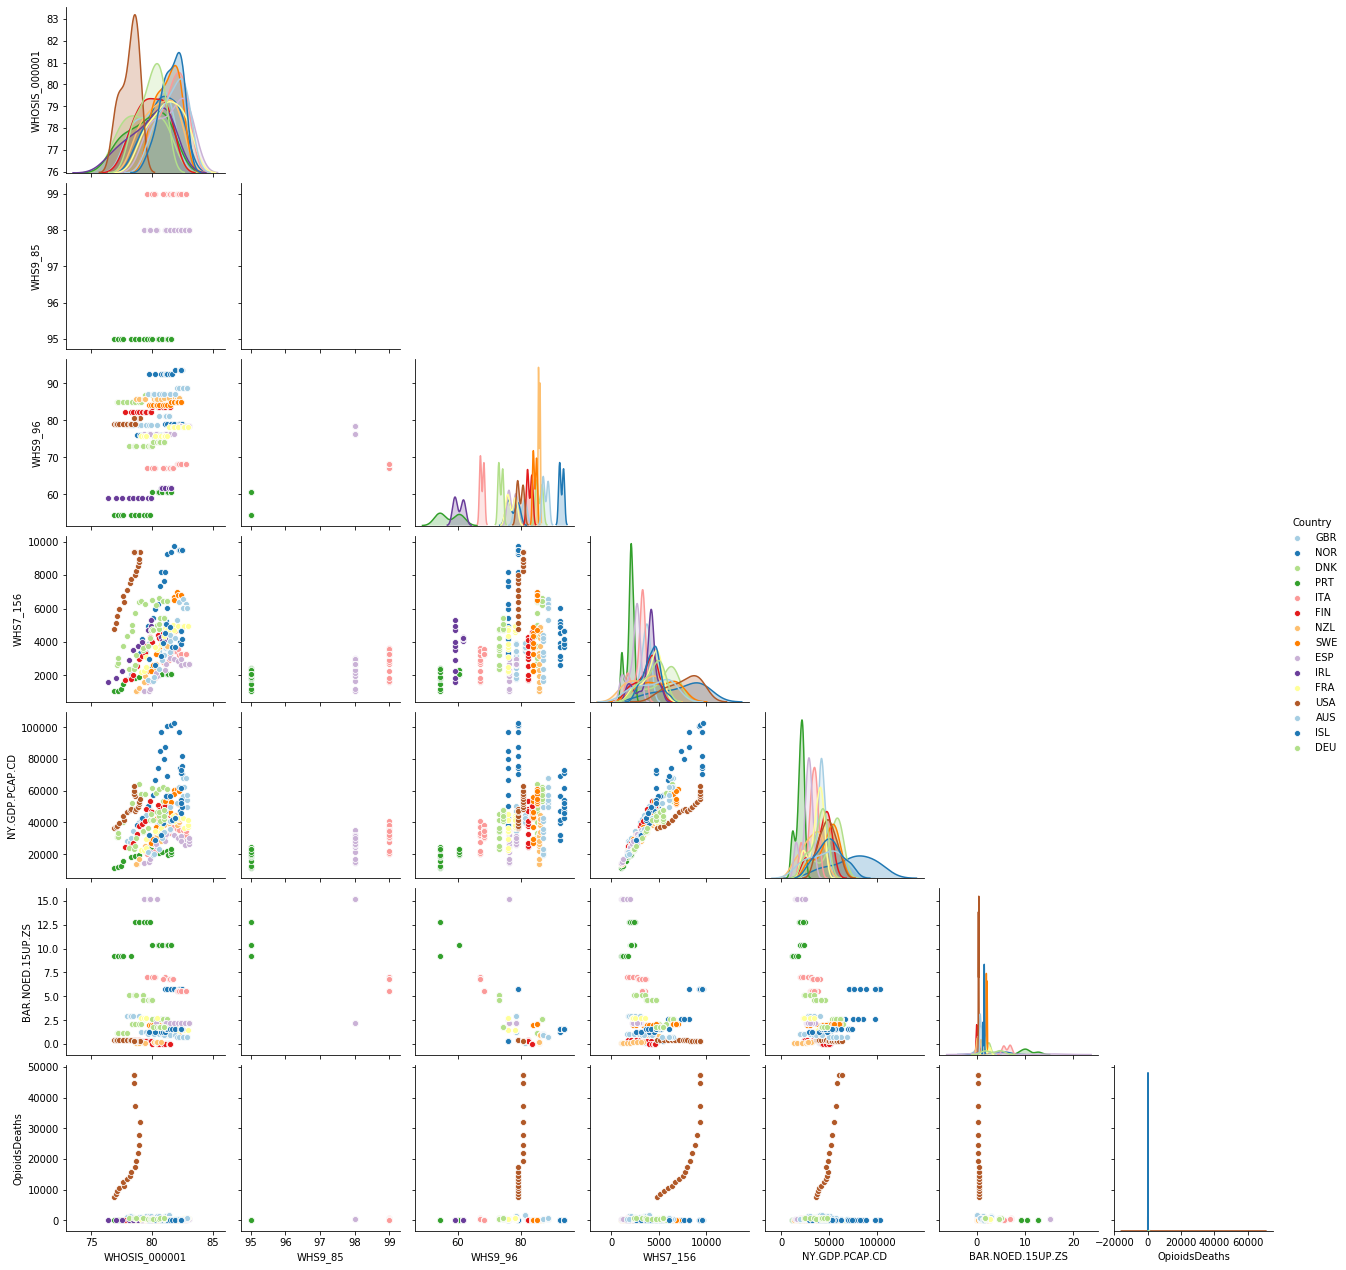

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

selected_indicators = [
  "WHOSIS_000001",       # Target - life expectancy
  "WHS9_85",             # Literacy rate among adults aged >= 15 years (%)
  "WHS9_96",             # Population living in urban areas (%)
  "WHS7_156",            # Per capita total expenditure on health at average exchange rate (US$)
  "NY.GDP.PCAP.CD",      # GDP per capita (current US$)
  "BAR.NOED.15UP.ZS",    # Barro-Lee: Percentage of population age 15+ with no education
  "OpioidsDeaths"
]

def hide_current_axis(*args, **kwds):
  plt.gca().set_visible(False)

pairplot_pd = input_df.select(['Country'] + list(map(lambda c: f"`{c}`", selected_indicators))).toPandas()
g = sns.pairplot(pairplot_pd, hue='Country', vars=selected_indicators, dropna=True, palette='Paired')
g.map_upper(hide_current_axis)

In the scatterplot, points are years and countries. Data from different countries are colored differently. Note that the USA (dark blue) stands out easily on many dimensions, particularly in the last row: opioid-related deaths.

Many key features aren't particularly correlated. A few are, like "GDP per capita (current US$)" vs "Per capita total expenditure on health at average exchange rate (US$)"; naturally nations with more economic production per capita spend more on health care. Again, the US stands out for spending relatively _more_ per capita than would be expected from GDP.

To make further sense of this, it's necessary to prepare the data for a machine learning model that can attempt to relate these many input features to the desired outcome, life expectancy.

In [0]:
%fs rm --recurse=true /tmp/KnowledgeRepo/ML/gartner_2020/featurized

res16: Boolean = true

In [0]:
from pyspark.sql.functions import col

# Simple one-hot encoding
countries = sorted(map(lambda r: r['Country'], input_df.select("Country").distinct().collect()))

with_countries_df = input_df
for country in countries:
  with_countries_df = with_countries_df.withColumn(f"Country_{country}", col("Country") == country)
  
with_countries_df = with_countries_df.drop("Country")
with_countries_df.write.format("delta").save("/tmp/KnowledgeRepo/ML/gartner_2020/featurized")

In [0]:
%sql
USE gartner;
CREATE TABLE IF NOT EXISTS gartner_2020_featurized USING DELTA LOCATION '/tmp/KnowledgeRepo/ML/gartner_2020/featurized';

We're going to go ahead and enable MLflow autologging for Spark data sources now, before they're used; this will be explained later.

In [0]:
import mlflow.spark
mlflow.spark.autolog()

Now, a 'gold' table of featurized data is available for data scientists and modelers to use for the modeling.

### Modeling

From here, data scientists may work in other frameworks like `pandas` to handle this small data set. In fact, those familiar with `pandas` can even manipulate and query data using Spark using the same API, via `koalas`, and then return to `pandas` DataFrames using the same API.

In [0]:
import databricks.koalas as ks

input_ks = spark.read.table("gartner.gartner_2020_featurized").to_koalas()
input_ks = input_ks[input_ks['Year'] <= 2016]

# Train/test split on <= 2014 vs 2015-2016
input_ks_train = input_ks[input_ks['Year'] <= 2014]
input_ks_test = input_ks[input_ks['Year'] > 2014]

X_ks_train = input_ks_train.drop('WHOSIS_000001', axis=1)
y_ks_train = input_ks_train['WHOSIS_000001']
X_ks_test = input_ks_test.drop('WHOSIS_000001', axis=1)
y_ks_test = input_ks_test['WHOSIS_000001']

X = input_ks.drop('WHOSIS_000001', axis=1).to_pandas()
y = input_ks['WHOSIS_000001'].to_pandas()
X_train = X_ks_train.to_pandas()
X_test =  X_ks_test.to_pandas()
y_train = y_ks_train.to_pandas()
y_test =  y_ks_test.to_pandas()

The data set is actually quite small -- 255 rows by about 1000 columns -- and consumes barely 2MB of memory. It's trivial to fit a model to this data with standard packages like `scikit-learn` or `xgboost`. However each of these models requires tuning, and needs building of 100 or more models to find the best combination.

In Databricks, the tool `hyperopt` can be use to build these models on a Spark cluster in parallel. The results are logged automatically to `mlflow`.

In [0]:
from math import exp
import xgboost as xgb
from hyperopt import fmin, hp, tpe, SparkTrials, STATUS_OK
import mlflow
import numpy as np

def params_to_xgb(params):
  return {
    'objective':        'reg:squarederror',
    'eval_metric':      'rmse',
    'max_depth':        int(params['max_depth']),
    'learning_rate':    exp(params['log_learning_rate']), # exp() here because hyperparams are in log space
    'reg_alpha':        exp(params['log_reg_alpha']),
    'reg_lambda':       exp(params['log_reg_lambda']),
    'gamma':            exp(params['log_gamma']),
    'min_child_weight': exp(params['log_min_child_weight']),
    #'importance_type':  'total_gain',
    'seed':             0
  }

def train_model(params):
  train = xgb.DMatrix(data=X_train, label=y_train)
  test = xgb.DMatrix(data=X_test, label=y_test)
  booster = xgb.train(params=params_to_xgb(params), dtrain=train, num_boost_round=1000,\
                      evals=[(test, "test")], early_stopping_rounds=50)
  mlflow.log_param('best_iteration', booster.attr('best_iteration'))
  return {'status': STATUS_OK, 'loss': booster.best_score, 'booster': booster.attributes()}

search_space = {
  'max_depth':            hp.quniform('max_depth', 20, 60, 1),
  # use uniform over loguniform here simply to make metrics show up better in mlflow comparison, in logspace
  'log_learning_rate':    hp.uniform('log_learning_rate', -3, 0),
  'log_reg_alpha':        hp.uniform('log_reg_alpha', -5, -1),
  'log_reg_lambda':       hp.uniform('log_reg_lambda', 1, 8),
  'log_gamma':            hp.uniform('log_gamma', -6, -1),
  'log_min_child_weight': hp.uniform('log_min_child_weight', -1, 4)
}

spark_trials = SparkTrials(parallelism=12)
best_params = fmin(fn=train_model, space=search_space, algo=tpe.suggest, max_evals=96, trials=spark_trials, rstate=np.random.RandomState(123))

Parallelism (12) is greater than the current total of Spark task slots (8). If dynamic allocation is enabled, you might see more executors allocated.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/96 [00:00<?, ?trial/s, best loss=?] 1%| | 1/96 [00:19<30:17, 19.13s/trial, best loss: 0.429747] 2%|▏ | 2/96 [00:46<33:42, 21.52s/trial, best loss: 0.411481] 3%|▎ | 3/96 [00:47<23:50, 15.38s/trial, best loss: 0.402409] 4%|▍ | 4/96 [00:51<18:20, 11.97s/trial, best loss: 0.402409] 5%|▌ | 5/96 [01:00<16:49, 11.09s/trial, best loss: 0.396663] 6%|▋ | 6/96 [01:19<20:12, 13.47s/trial, best loss: 0.396663] 7%|▋ | 7/96 [01:55<30:01, 20.24s/trial, best loss: 0.396663] 8%|▊ | 8/96 [02:03<24:18, 16.57s/trial, best loss: 0.396663] 9%|▉ | 9/96 [02:10<19:52, 13.71s/trial, best loss: 0.396663] 10%|█ | 10/96 [02:27<21:04, 14.71s/trial, best loss: 0.396663] 11%|█▏ | 11/96 [02:59<28:12, 19.91s/trial, best loss: 0.396663] 12%|█▎ | 12/96 [03:12<25:00, 17.86s/trial, best loss: 0.393259] 14%|█▎ | 13/96 [03:22<21:27, 15.51s/trial, best loss: 0.393259] 15%|█▍ | 14/96 [03:23<15:16, 11.18s/trial, best loss: 0.35621]  16%|█▌ | 15/96 [03:30<13:25, 9.94s/trial, best loss: 0.346034] 17%|█▋ | 16/96 [03:32<10:05, 7.57s/trial, best loss: 0.346034] 18%|█▊ | 17/96 [03:36<08:34, 6.52s/trial, best loss: 0.301451] 19%|█▉ | 18/96 [03:37<06:19, 4.87s/trial, best loss: 0.301451] 20%|█▉ | 19/96 [03:38<04:46, 3.72s/trial, best loss: 0.301451] 21%|██ | 20/96 [03:40<04:03, 3.21s/trial, best loss: 0.301451] 23%|██▎ | 22/96 [03:42<03:08, 2.55s/trial, best loss: 0.301451] 25%|██▌ | 24/96 [03:43<02:19, 1.94s/trial, best loss: 0.301451] 26%|██▌ | 25/96 [03:47<02:44, 2.32s/trial, best loss: 0.301451] 28%|██▊ | 27/96 [03:48<02:02, 1.77s/trial, best loss: 0.301451] 30%|███ | 29/96 [03:49<01:33, 1.40s/trial, best loss: 0.301451] 32%|███▏ | 31/96 [03:55<02:02, 1.89s/trial, best loss: 0.301451] 33%|███▎ | 32/96 [03:56<01:44, 1.63s/trial, best loss: 0.301451] 35%|███▌ | 34/96 [03:59<01:39, 1.60s/trial, best loss: 0.301451] 36%|███▋ | 35/96 [04:00<01:27, 1.43s/trial, best loss: 0.301451] 38%|███▊ | 36/96 [04:03<01:55, 1.92s/trial, best loss: 0.301451] 39%|███▊ | 37/96 [04:05<01:54, 1.95s/trial, best loss: 0.301451] 40%|███▉ | 38/96 [04:07<01:54, 1.97s/trial, best loss: 0.301451] 41%|████ | 39/96 [04:11<02:27, 2.59s/trial, best loss: 0.301451] 42%|████▏ | 40/96 [04:18<03:39, 3.92s/trial, best loss: 0.301451] 43%|████▎ | 41/96 [04:27<04:59, 5.45s/trial, best loss: 0.301451] 44%|████▍ | 42/96 [04:29<03:58, 4.42s/trial, best loss: 0.301451] 45%|████▍ | 43/96 [04:34<04:03, 4.60s/trial, best loss: 0.301451] 46%|████▌ | 44/96 [04:36<03:19, 3.83s/trial, best loss: 0.301451] 47%|████▋ | 45/96 [04:39<03:02, 3.59s/trial, best loss: 0.301451] 48%|████▊ | 46/96 [04:43<03:05, 3.72s/trial, best loss: 0.301451] 50%|█████ | 48/96 [04:46<02:27, 3.06s/trial, best loss: 0.273493] 51%|█████ | 49/96 [04:52<03:06, 3.96s/trial, best loss: 0.273493] 53%|█████▎ | 51/96 [04:57<02:38, 3.53s/trial, best loss: 0.273493] 54%|█████▍ | 52/96 [05:02<02:55, 3.98s/trial, best loss: 0.273493] 55%|█████▌ | 53/96 [05:03<02:12, 3.09s/trial, best loss: 0.273493] 56%|█████▋ | 54/96 [05:06<02:09, 3.08s/trial, best loss: 0.273493] 57%|█████▋ | 55/96 [05:09<02:05, 3.06s/trial, best loss: 0.273493] 58%|█████▊ | 56/96 [05:12<02:01, 3.05s/trial, best loss: 0.273493] 59%|█████▉ | 57/96 [05:20<02:45, 4.24s/trial, best loss: 0.273493] 60%|██████ | 58/96 [05:22<02:15, 3.58s/trial, best loss: 0.273493] 61%|██████▏ | 59/96 [05:26<02:17, 3.71s

The resulting runs and their hyperparameters can be visualized in the mlflow tracking server, via Databricks:

<img width="800" src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/gartner_2020/hyperopt.png"/>

Root mean squared error was about 0.3 years, compared to life expectancies ranging from about 77 to 83 years. With a best set of hyperparameters chosen, the final model is re-fit and logged with `mlflow`, along with an analysis of feature importance from `shap`:

In [0]:
code_lookup_df = spark.read.table("gartner.descriptions")
code_lookup = dict([(r['Code'], r['Description']) for r in code_lookup_df.collect()])
display_cols = [code_lookup[c] if c in code_lookup else c for c in X.columns]

In [0]:
import mlflow
import mlflow.xgboost
import shap
import matplotlib.pyplot as plt
from mlflow.models.signature import infer_signature

plt.close()

with mlflow.start_run() as run:
  best_iteration = int(spark_trials.best_trial['result']['booster']['best_iteration'])
  booster = xgb.train(params=params_to_xgb(best_params), dtrain=xgb.DMatrix(data=X, label=y), num_boost_round=best_iteration)
  mlflow.log_params(best_params)
  mlflow.log_param('best_iteration', best_iteration)
  mlflow.xgboost.log_model(booster, "xgboost", input_example=X.head(), signature=infer_signature(X, y))

  shap_values = shap.TreeExplainer(booster).shap_values(X, y=y)
  shap.summary_plot(shap_values, X, feature_names=display_cols, plot_size=(14,6), max_display=10, show=False)
  plt.savefig("summary_plot.png", bbox_inches="tight")
  plt.close()
  mlflow.log_artifact("summary_plot.png")
  
  best_run = run.info

2020/10/17 15:58:21 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under dbfs:/databricks/mlflow/8447156/a694c1edf0ff4bb09934eac2fdeefca8/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc. Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing

This model can then be registered as the current candidate model for further evaluation in the Model Registry:

<img width="800" src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/gartner_2020/registry.png"/>

In [0]:
import time

model_name = "gartner_2020"
client = mlflow.tracking.MlflowClient()
try:
  client.create_registered_model(model_name)
except Exception as e:
  pass

model_version = client.create_model_version(model_name, f"{best_run.artifact_uri}/xgboost", best_run.run_id)

time.sleep(5) # Just to make sure it's had a second to register
client.transition_model_version_stage(model_name, model_version.version, stage="Staging")

Out[22]: <ModelVersion: creation_timestamp=1602950308787, current_stage='Staging', description='', last_updated_timestamp=1602950313855, name='', run_id='a694c1edf0ff4bb09934eac2fdeefca8', run_link='', source='dbfs:/databricks/mlflow/8447156/a694c1edf0ff4bb09934eac2fdeefca8/artifacts/xgboost', status='READY', status_message='', tags={}, user_id='100682', version='30'>

### Model Interpretation

From there the question is, what features seem to predict life expectancy? Given the relatively limited span of data, and the limitations of what models can tell us about causality, interpretation requires some care. We applied the package `shap` using Databricks to attempt to explain what the model learned in a principled way, and can now view the logged plot:

In [0]:
client = mlflow.tracking.MlflowClient()
latest_model_detail = client.get_latest_versions("gartner_2020", stages=['Staging'])[0]
client.download_artifacts(latest_model_detail.run_id, "summary_plot.png", "/dbfs/FileStore/tmp/KnowledgeRepo/ML/")

Out[23]: '/dbfs/FileStore/tmp/KnowledgeRepo/ML/summary_plot.png'

![](/files/tmp/KnowledgeRepo/ML/summary_plot.png)

The two most important features that stand out by far are:
- Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)
- Year

The horizontal axis units are years of life expectancy. It is not the rate of change of life expectancy with respect to the feature value, but the average effect (positive or negative) that the feature's particular value explains per country and year over the data set. Each country and year is a dot, and red dots indicate high values of the feature.

Year is self-explanatory; clearly there is generally an upward trend in life expectancy per time, with an average absolute of effect of 0.3 years. But mortality from cardiac diseases, cancer, and diabetes explains even more. Higher %s obviously explain lower life expectancy, as seen at the left.

None of these necessarily cause life expectancy directly, but as a first pass, these are suggestive of factors that at least correlate over the last 20 years.

SHAP can produce an interaction plot to further study the effect of the most-significant feature. Its built-in `matplotlib`-based plots render directly.

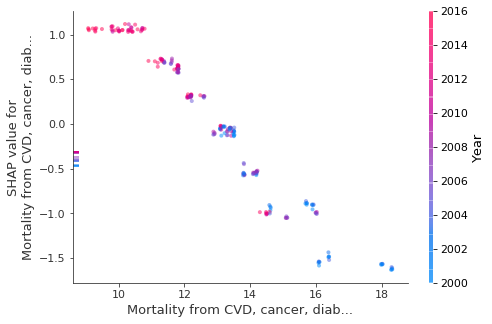

In [0]:
import numpy as np
import mlflow
import mlflow.xgboost
import shap

model = mlflow.xgboost.load_model(latest_model_detail.source)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, y=y)

feature = "SH.DYN.NCOM.ZS"
feature_loc = X.columns.get_loc(feature)
interactions = explainer.shap_interaction_values(X).mean(axis=0)
interactions[feature_loc] = 0 # don't consider feature itself as interaction
max_interaction = np.argmax(np.abs(interactions[feature_loc]))

def abbrev(c):
  return c if len(c) < 32 else c[0:32]+"..."
abbrev_display_cols = [abbrev(c) for c in display_cols]
display(shap.dependence_plot(abbrev(code_lookup["SH.DYN.NCOM.ZS"]), shap_values, X, x_jitter=0.5, alpha=0.5, interaction_index=max_interaction, feature_names=abbrev_display_cols))

Each point is a country and year. This plots the mortality rate mentioned above (`SH.DYN.NCOM.ZS`) versus SHAP value -- the effect on predicted life expectancy that this particular mortality rate has in that time and place. Of course, higher mortality rates are associated with lower predicted life expectancy.

Colors correspond to years, which was selected as a feature that most strongly interacts with mortality rate. It's also not surprising that in later years (red), mortality rate is lower and thus life expectancy higher. There is a mild secondary trend here, seen if comparing the curve of blue points (longer go) to red point (more recent). Predicted life expectancy, it might be said, varies less with this mortality rate recently than in the past.

The United States stood out as an outlier in the life expectancy plot above. We might instead ask, how is the USA different relative to other countries. SHAP can help explain how features explain predicted life expectancy differently.

In [0]:
us_delta = shap_values[X['Country_USA']].mean(axis=0) - shap_values[~X['Country_USA']].mean(axis=0)
importances = list(zip([float(f) for f in us_delta], display_cols))
top_importances = sorted(importances, key=lambda p: abs(p[0]), reverse=True)[:10]
display(spark.createDataFrame(top_importances, ["Mean SHAP delta", "Feature"]))

Mean SHAP delta Feature -1.2433778047561646 Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%) -0.4178072512149811 Income share held by highest 10% -0.2691701352596283 Net intake rate to Grade 1 of primary education by under-age entrants (-1 year), female (%) -0.24992983043193817 School enrollment, preprimary (% gross) -0.1468467265367508 Neonatal mortality rate (per 1000 live births) -0.07450807094573975 TIMSS: Mean performance on the mathematics scale for fourth grade students, total -0.04827245697379112 Adolescent fertility rate (births per 1,000 women ages 15-19) -0.03899382799863815 Adjusted savings: particulate emission damage (% of GNI) 0.03380780667066574 Population living in urban areas (%) -0.03266345337033272 Year

Mortality rate due to cardiac disease, diabetes and cancer stands out in the USA. On average, it explains almost a year less life expectancy than in other countris.

This model can now be moved to Production, for consumption and deployment for inference:

In [0]:
client.transition_model_version_stage(model_name, latest_model_detail.version, stage="Production")

Out[26]: <ModelVersion: creation_timestamp=1602950308787, current_stage='Production', description='', last_updated_timestamp=1602950475126, name='', run_id='a694c1edf0ff4bb09934eac2fdeefca8', run_link='', source='dbfs:/databricks/mlflow/8447156/a694c1edf0ff4bb09934eac2fdeefca8/artifacts/xgboost', status='READY', status_message='', tags={}, user_id='100682', version='30'>

PS we're going to save off a JSON representation of an input for usage a little later:

In [0]:
print(X.head(1).to_json(orient='records'))

[{"Year":2008,"CHOLERA_0000000001":2.0,"CHOLERA_0000000002":0.0,"CHOLERA_0000000003":0.0,"CM_01":2975.0,"CM_02":2456.0,"CM_03":1644.0,"DEVICES09":null,"DEVICES22":6.4299998283,"HIV_0000000020":null,"MDG_0000000001":3.6276299953,"MDG_0000000005":66.1999969482,"MDG_0000000006":null,"MDG_0000000007":4.3770499229,"MDG_0000000017":0.4600000083,"MDG_0000000020":5.9000000954,"MDG_0000000023":8.0,"MDG_0000000025":98.6999969482,"MDG_0000000026":6.0,"MDG_0000000027":1.2999999523,"MDG_0000000029":0.1000000015,"MDG_0000000031":68.0,"MDG_0000000033":null,"MH_17":0.3353399932,"MH_18":0.4907700121,"MH_6":13.2019195557,"NUTRITION_564":1.0,"SA_0000001688":13.3818902969,"TB_1":87.0,"TB_tot_newrel":3664.0,"WHOSIS_000003":2.4322500229,"WHOSIS_000005":null,"WHOSIS_000009":3.5,"WHS10_1":2011.0,"WHS10_8":100.0,"WHS10_9":10.7001695633,"WHS2_138":null,"WHS2_174":8.0,"WHS3_40":4.0,"WHS3_41":0.0,"WHS3_42":null,"WHS3_43":12260.0,"WHS3_45":0.0,"WHS3_46":8.0,"WHS3_49":0.0,"WHS3_50":0.0,"WHS3_52":null,"WHS3_53":837.0,"WHS3_55":1.0,"WHS3_56":0.0,"WHS3_57":151.0,"WHS3_62":917.0,"WHS4_100":96.0,"WHS4_111":null,"WHS4_115":30.5,"WHS4_117":87.0,"WHS4_129":94.0,"WHS4_154":null,"WHS6_102":82.0629997253,"WHS6_123":63485.0,"WHS6_127":895000.0,"WHS6_140":null,"WHS6_144":7.6700000763,"WHS6_148":108.1999969482,"WHS6_150":null,"WHS6_517":49904.0,"WHS6_518":null,"WHS6_519":6.0300002098,"WHS6_520":null,"WHS7_103":39.0182685852,"WHS7_104":3606.4680175781,"WHS7_105":3989.5395507812,"WHS7_108":3033.3796386719,"WHS7_113":18.1345500946,"WHS7_120":0.0,"WHS7_134":88.3169784546,"WHS7_139":57.5040016174,"WHS7_143":10.3924703598,"WHS7_147":23.9666805267,"WHS7_149":76.0333175659,"WHS7_156":4743.2729492188,"WHS8_110":97.0,"WHS9_85":null,"WHS9_86":81915.0,"WHS9_88":45.0900001526,"WHS9_89":13.0894699097,"WHS9_90":null,"WHS9_91":100.0,"WHS9_92":65.3956832886,"WHS9_93":37550.0,"WHS9_95":1.4589999914,"WHS9_96":73.0670013428,"WHS9_CBR":8.5,"WHS9_CDR":10.6000003815,"WHS9_CS":127.0,"AG.AGR.TRAC.NO":989488.0,"AG.CON.FERT.PT.ZS":55.6782980077,"AG.CON.FERT.ZS":159.5827187395,"AG.LND.AGRI.K2":169210.0,"AG.LND.AGRI.ZS":48.5356968706,"AG.LND.ARBL.HA":11932000.0,"AG.LND.ARBL.HA.PC":0.1453170857,"AG.LND.ARBL.ZS":34.2253965522,"AG.LND.CREL.HA":7038419.0,"AG.LND.CROP.ZS":0.5736740957,"AG.LND.EL5M.RU.K2":12582.6123,"AG.LND.EL5M.RU.ZS":3.552068118,"AG.LND.EL5M.UR.K2":3211.480957,"AG.LND.EL5M.UR.ZS":0.906600223,"AG.LND.EL5M.ZS":4.458668341,"AG.LND.FRST.K2":113990.0,"AG.LND.FRST.ZS":32.6965550871,"AG.LND.IRIG.AG.ZS":1.384397534,"AG.LND.PRCP.MM":700.0,"AG.LND.TOTL.K2":348630.0,"AG.LND.TOTL.RU.K2":291859.2188,"AG.LND.TOTL.UR.K2":62374.19922,"AG.LND.TRAC.ZS":838.264994917,"AG.PRD.CREL.MT":50104858.0,"AG.PRD.CROP.XD":103.53,"AG.PRD.FOOD.XD":103.98,"AG.PRD.LVSK.XD":104.2,"AG.SRF.TOTL.K2":357110.0,"AG.YLD.CREL.KG":7118.8,"BAR.NOED.1519.ZS":3.62,"BAR.NOED.15UP.ZS":4.63,"BAR.NOED.2024.ZS":3.62,"BAR.NOED.2529.ZS":2.64,"BAR.NOED.25UP.ZS":4.8,"BAR.NOED.3034.ZS":2.67,"BAR.NOED.3539.ZS":2.55,"BAR.NOED.4044.ZS":2.73,"BAR.NOED.4549.ZS":2.75,"BAR.NOED.5054.ZS":3.0,"BAR.NOED.5559.ZS":5.65,"BAR.NOED.6064.ZS":6.91,"BAR.POP.1519":4873.0,"BAR.POP.15UP":70864.0,"BAR.POP.2024":4926.0,"BAR.POP.2529":4635.0,"BAR.POP.25UP":61065.0,"BAR.POP.3034":5171.0,"BAR.POP.3539":6960.0,"BAR.POP.4044":7187.0,"BAR.POP.4549":6291.0,"BAR.POP.5054":5754.0,"BAR.POP.5559":4345.0,"BAR.POP.6064":5197.0,"BAR.PRM.CMPT.1519.ZS":35.27,"BAR.PRM.CMPT.15UP.ZS":4.15,"BAR.PRM.CMPT.2024.ZS":2.67,"BAR.PRM.CMPT.2529.ZS":2.56,"BAR.PRM.CMPT.25UP.ZS":2.23,"BAR.PRM.CMPT.3034.ZS":2.79,"BAR.PRM.CMPT.3539.ZS":2.35,"BAR.PRM.CMPT.4044.ZS":2.33,"BAR.PRM.CMPT.4549.ZS":2.18,"BAR.PRM.CMPT.5054.ZS":2.19,"BAR.PRM.CMPT.5559.ZS":2.26,"BAR.PRM.CMPT.6064.ZS":2.23,"BAR.PRM.ICMP.1519.ZS":38.12,"BAR.PRM.ICMP.15UP.ZS":5.31,"BAR.PRM.ICMP.2024.ZS":3.08,"BAR.PRM.ICMP.2529.ZS":3.07,"BAR.PRM.ICMP.25UP.ZS":2.92,"BAR.PRM.ICMP.3034.ZS":3.33,"BAR.PRM.ICMP.3539.ZS":2.94,"BAR.PRM.ICMP.4044.ZS":2.93,"BAR.PRM.ICMP.4549.ZS":2.85,"BAR.PRM.ICMP.5054.ZS":2.84,"BAR.PRM.ICMP.5559.ZS":3.0,"BAR.PRM.ICMP.606

## Moving to Production

In [0]:
import mlflow
import mlflow.pyfunc
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

# Get latest model
model_udf = mlflow.pyfunc.spark_udf(spark, "models:/gartner_2020/production")

future_input_df = spark.read.table("gartner.gartner_2020_featurized").drop("WHOSIS_000001").filter("Year > 2016")

quoted_cols = list(map(lambda c: f"`{c}`", future_input_df.columns))
with_prediction_df = future_input_df.withColumn("WHOSIS_000001", model_udf(*quoted_cols))

In [0]:
# Unencode country for display
country_cols = [c for c in with_prediction_df.columns if c.startswith("Country_")]
def unencode_country(*is_country):
  for i in range(len(country_cols)):
    if is_country[i]:
      return country_cols[i][-3:]
    
unencode_country_udf = udf(unencode_country, StringType())

country_unencoded_df = with_prediction_df.withColumn("Country", unencode_country_udf(*country_cols)).drop(*country_cols)

display(country_unencoded_df.select(col("Year"), col("Country"), col("WHOSIS_000001").alias("LifeExpectancy")).orderBy("Year", "Country"))

Year Country LifeExpectancy 2017 AUS 82.72924041748047 2017 DEU 80.95414733886719 2017 DNK 81.31370544433594 2017 ESP 82.81697845458984 2017 FIN 81.50498962402344 2017 FRA 82.72058868408203 2017 GBR 81.4625473022461 2017 IRL 81.33262634277344 2017 ISL 82.40116882324219 2017 ITA 82.6671142578125 2017 NOR 82.32470703125 2017 NZL 82.24066925048828 2017 PRT 81.43896484375 2017 SWE 82.33941650390625 2017 USA 78.42740631103516 2018 AUS 82.71309661865234 2018 DEU 80.97201538085938 2018 DNK 81.27902221679688 2018 ESP 82.79499816894531 2018 FIN 81.50434112548828 2018 FRA 82.73651885986328 2018 GBR 81.50464630126953 2018 IRL 81.40477752685547 2018 ISL 82.3730239868164 2018 ITA 82.62923431396484 2018 NOR 82.3533706665039 2018 NZL 82.2681655883789 2018 PRT 81.52555084228516 2018 SWE 82.3456039428711 2018 USA 78.46246337890625

In [0]:
input_df = spark.read.table("gartner.gartner_2020")
display(input_df.filter("Year <= 2016").select(col("Year"), col("Country"), col("WHOSIS_000001").alias("LifeExpectancy")).union(
  country_unencoded_df.select(col("Year"), col("Country"), col("WHOSIS_000001").alias("LifeExpectancy"))))

Year Country LifeExpectancy 2015 AUS 82.5808334350586 2002 DNK 77.21485137939453 2010 FIN 80.02410125732422 2008 FRA 81.0986328125 2011 GBR 81.05516815185547 2007 ISL 81.26934814453125 2003 FIN 78.7317886352539 2011 NZL 80.98924255371094 2013 ISL 82.50425720214844 2001 SWE 79.95345306396484 2007 FRA 81.01750183105469 2009 GBR 80.41708374023438 2013 NOR 81.8525619506836 2014 FIN 81.10089874267578 2002 AUS 80.15123748779297 2004 FRA 80.39885711669922 2009 ITA 81.75298309326172 2013 USA 78.94818115234375 2015 IRL 81.39015197753906 2004 ESP 80.39457702636719 2013 FIN 80.93609619140625 2005 FRA 80.28153228759766 2014 GBR 81.42310333251953 2002 DEU 78.61576843261719 2007 PRT 79.32829284667969 2005 SWE 80.61920166015625 2003 ESP 79.8227310180664 2005 NOR 80.27078247070312 2008 PRT 79.6015625 2011 ITA 82.16773986816406 2016 ITA 82.77284240722656 2012 GBR 81.12748718261719 2008 NZL 80.4088363647461 2008 NOR 80.7711181640625 2015 FIN 81.39797973632812 2006 IRL 79.19621276855469 2006 PRT 78.92096710205078 2007 GBR 79.74722290039062 2001 DNK 77.2406005859375 2016 DEU 81.00277709960938 2010 FRA 81.3902816772461 2015 PRT 81.30927276611328 2007 DNK 78.60397338867188 2010 ITA 82.04792785644531 2009 DEU 80.00248718261719 2016 IRL 81.53662872314453 2014 ITA 82.83949279785156 2002 PRT 77.46824645996094 2003 NOR 79.70053100585938 2005 PRT 78.59058380126953 2009 AUS 81.88072204589844 2011 USA 78.8199462890625 2000 IRL 76.41195678710938 2015 SWE 82.14144134521484 2000 USA 76.91159057617188 2009 SWE 81.45159149169922 2008 AUS 81.47183227539062 2002 USA 77.13555145263672 2013 AUS 82.78154754638672 2010 ESP 82.1355972290039 2013 GBR 81.20089721679688 2006 ITA 81.39053344726562 2011 NOR 81.25372314453125 2012 ESP 82.39737701416016 2011 FIN 80.46553039550781 2006 DEU 79.68672180175781 2009 ISL 81.68534851074219 2009 FIN 79.91969299316406 2004 GBR 78.96793365478516 2016 NZL 82.24739074707031 2001 FRA 79.32330322265625 2016 PRT 81.5262680053711 2007 IRL 79.65735626220703 2012 FRA 81.80441284179688 2000 SWE 79.74405670166016 2015 GBR 81.1185531616211 2007 NOR 80.62032318115234 2009 NOR 80.9908218383789 2010 PRT 79.97952270507812 2003 DNK 77.58341979980469 2004 SWE 80.44793701171875 2014 ESP 83.01248168945312 2009 ESP 81.8138198852539 2007 FIN 79.50602722167969 2011 FRA 81.76258850097656 2009 NZL 80.70767211914062 2012 NZL 81.36628723144531 2004 IRL 78.45681762695312 2010 DNK 79.39053344726562 2006 FIN 79.4626235961914 2003 GBR 78.44397735595703 2005 FIN 79.20745086669922 2002 IRL 77.55004119873047 2015 NOR 82.32866668701172 2000 ESP 79.3720932006836 2010 USA 78.716552734375 2001 FIN 78.2708969116211 2003 ISL 80.8779525756836 2013 NZL 81.86168670654297 2016 FRA 82.9460220336914 2003 USA 77.29466247558594 2016 USA 78.49758911132812 2016 GBR 81.43250274658203 2006 NZL 80.12825012207031 2001 AUS 80.0813217163086 2014 FRA 82.56790161132812 2012 IRL 80.8650131225586 2006 ISL 81.19303131103516 2015 USA 78.62655639648438 2008 DEU 79.92101287841797 2004 DNK 77.94473266601562 2009 DNK 79.13619232177734 2004 ITA 81.03214263916016 2016 NOR 82.47630310058594 2003 ITA 80.16764831542969 2006 USA 77.90643310546875 2002 ISL 80.71708679199219 2015 ISL 82.39936828613281 2007 ITA 81.47754669189453 2014 PRT 81.23252868652344 2015 NZL 82.02245330810547 2016 FIN 81.44721221923828 2016 SWE 82.3634262084961 2009 IRL 79.92729949951172 2011 AUS 82.19225311279297 2013 FRA 82.11892700195312 2000 AUS 79.64923095703125 2006 SWE 80.88416290283203 2012 DNK 80.31646728515625 2001 GBR 78.1727066040039 2010 DEU 80.12474822998047 2000 GBR 77.91763305664062 2010 NZL 81.21929168701172 2008 GBR 79.90194702148438 2009 USA 78.5839614868164 2002 ESP 79.87291717529297 2012 AUS 82.53964233398438 2003 IRL 78.10399627685547 2015 DEU 80.63511657714844 2000 DNK 77.08438873291016 2010 IRL 80.86634826660156 2000 NOR 78.75833892822266 2002 NZL 78.96221160888672 2007 SWE 81.0447769165039 2010 AUS 82.03266143798828 2005 GBR 79.12409210205078 2016 ISL 82.39584350585938 2012 SWE 81.84496307373047 2000 FIN 77.77

The projected life expectancy can be plotted with previous known values. If the trends seem a little flat, it's because most of the real data is not yet available in the years 2017-2018 at this time. Imputed data fills the gaps, and causes predictions to be relatively similar to 2016.

## Real-Time model serving

The model can also be served as a REST API, accepting JSON-formatted requests to an endpoint that can be run on Azure ML, AWS SageMaker, or, even within Databricks for testing and low-throughput use cases.

Enable Serving of the model in the Model Registry. You can send the JSON snippet above to the service this way:

<img width="800" src="https://databricks-knowledge-repo-images.s3.us-east-2.amazonaws.com/ML/gartner_2020/serving.png"/>

## "What-If?" and Dashboarding

Finally, this model can power a simple dashboard, where an analyst can change values and see updated predictions reflected in a plot. In this case, the dashboard shows predicted life expectancy over time for the USA, where a single feature is varied over a range.

Switch to the View for Dashboard "WhatIfGartner2020".

Try changing the Feature widget above and changing the range of values. The heatmap re-renders.

In [0]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model = mlflow.xgboost.load_model("models:/gartner_2020/production")

future_input_pd = spark.read.table("gartner.gartner_2020_featurized").drop("WHOSIS_000001").filter("Country_USA").orderBy("Year").toPandas()

dbutils.widgets.removeAll()
dbutils.widgets.dropdown("Feature", "SH.DYN.NCOM.ZS", ["WHS9_96", "SH.DYN.NCOM.ZS"], "Feature")
dbutils.widgets.text("From", "0", "From")
dbutils.widgets.text("To", "30", "To")

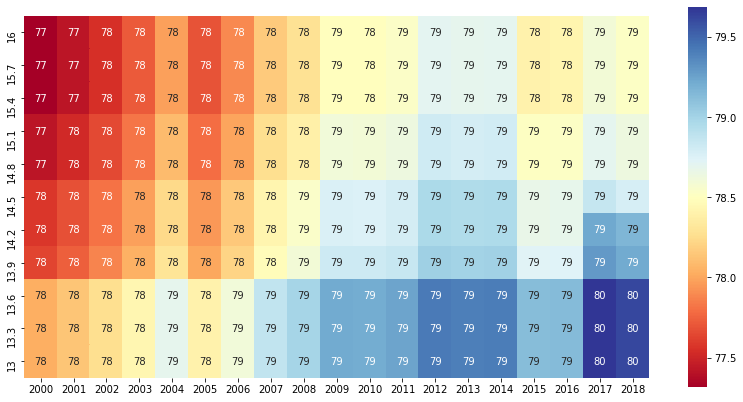

In [0]:
feature = dbutils.widgets.get("Feature")
from_val = float(dbutils.widgets.get("From"))
to_val = float(dbutils.widgets.get("To"))

count = 10
range_val = [to_val - (to_val - from_val) * i / count for i in range(count+1)]
range_year = [2000 + i for i in range(19)]

predictions = np.zeros((len(range_val), len(range_year)))
for i in range(len(range_val)):
  widget_input_pd = future_input_pd.copy()
  widget_input_pd[feature] = range_val[i]
  predictions[i,:] = model.predict(xgb.DMatrix(data=widget_input_pd))

plt.close()
plt.figure(figsize=(14, 7))
yticks = [f"{r:.3f}".rstrip('0').rstrip('.') for r in range_val]
display(sns.heatmap(pd.DataFrame(predictions, index=range_val, columns=range_year), cmap='RdYlBu', annot=True, square=True, yticklabels=yticks))